# 0.0. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import datetime
import xgboost as xgb
from tabulate import tabulate
import pickle
import warnings


from scipy                 import stats as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
#setting seaborn style
sns.set_style('darkgrid')
sns.set_palette('muted')

# sets to display unlimited number of columns
pd.options.display.max_columns = None

# setting the title and axis labels
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)


#cramer V function
def cramer_v(var_x, var_y):
    # builds contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    #sum of all values in the matrix
    n = confusion_matrix.sum()
    
    # rows, cols
    r, k = confusion_matrix.shape
    
    #chi-squared
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    
    # bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    #returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])    

In [3]:
#cross validation function
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #start and date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error( 'Linear regression', np.expm1(yvalidation), np.expm1(yhat))
    
        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('C:/Users/diasn/projetos/DataScienceEmProducao/data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('C:/Users/diasn/projetos/DataScienceEmProducao/data/store.csv', low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
505605,181,5,2014-04-04,7146,750,1,1,0,0,a,a,12610.0,3.0,2013.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


# 1.0. STEP 01 - DATA DESCRIPTIONS

In this first step, we will make the data descriptions to know how challeging the problem is. We need this analyses to better understand the aspects of the data as:

 - Quatity of data - Do we have the resources to work ?
 - Kind of variables - What kind of variables do we have ?
 - Amount of missing data - How much missing data do we have ? What is the motivation for missing data ?
 - Descritive Statistics
  
Before of all, let's to save a copy of the dataset.

In [6]:
#saving the copy
df1 = df_raw.copy()

Now, let's rename the columns according to the code

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new


In [8]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.2. Data Dimensions

To know the size of the data set we apply the following commands

In [9]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

Let's transform the 'date' column from object type to datetime type.

In [10]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In the case of the variables that have missing data, we will check with following comand

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

We can see that there are many missing data. We must resolve this situation so that the prediction model can learn. One way to do this is to create data with reference in the available we have.

## 1.5. Fillout NA - Do away with data missing

As written above, we will do away with data missing. So, we have the codes

In [12]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis = 1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                               else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis = 1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis = 1)

#promo_inteval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split(',') 
                                                             else 0, axis = 1)


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

By applying the codes, we can see that the missing data has been filled in.

## 1.6. Change Types

Here, we will check the change types in the variables that need to be considered because for use it has to be in its correct format. Therefore,

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

By observing above, we can see that the variables 'competition_open_since_month', 'competition_open_since_month', 'promo2_since_week' and 'promo_since_year' are in float formats. We need to turn these variables to integer. Soon,

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

It is through the descriptive statistics that we are able to get a notion from the business. It helps detect some errors.

Thereare two big metrics that we have to keep our eyes on: data distribution and central tendency.

Central tendency: summary statistics like median, mean, max, min, quantiles.

Data distribution: we need to know how the data is distributed around the median and mean.

Other important statistics: skewness and kurtosis.

Also, check how variabless behave and look for negative values that shouldn't be.

In [16]:
#numerical attributes
num_attributes = df1.select_dtypes(include = ['int32', 'int64', 'float64'])

#categorical attributes
cat_attributes = df1.select_dtypes(exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [17]:
#Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [18]:
#summary statistics
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


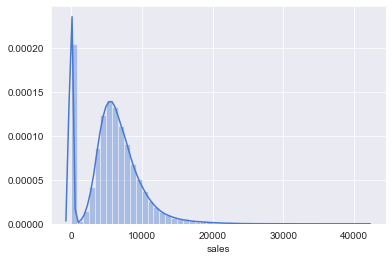

In [19]:
# plotting sales - response variable
sns.distplot(df1['sales']);

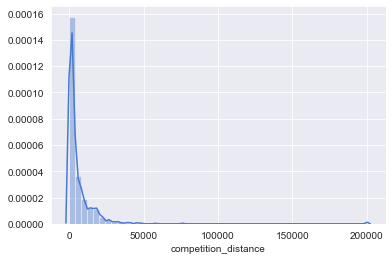

In [20]:
# plotting competition distance
sns.distplot(df1['competition_distance']);

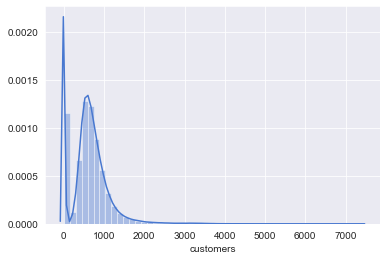

In [21]:
# plotting customers
sns.distplot(df1['customers']);

### 1.7.2 Categorical Attributes

In [22]:
# checking categorical attributes
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

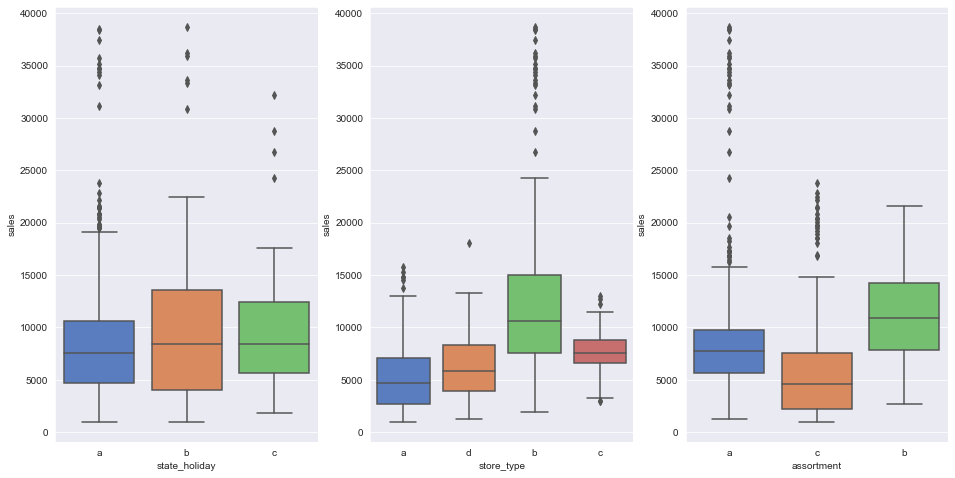

In [23]:
# plotting boxplots categorical attributes

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# uses the variable ax for single a Axes
fig, gr = plt.subplots()

# figure size
gr.figure.set_size_inches(16,8)

# plots
plt.subplot(1, 3, 1)
gr = sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1 )

plt.subplot(1, 3, 2)
gr = sns.boxplot(x = 'store_type', y = 'sales', data = aux1 )

plt.subplot(1, 3, 3)
gr = sns.boxplot(x = 'assortment', y = 'sales', data = aux1 )

#display plot
plt.show()

# 2.0. STEP 02 - FEATURING ENGINEERING 

In this step, we did Feature Engineering for to have the disponible variables for study during the Exploratory Data Analysis.
But first, let's make a copy of the document.

In [24]:
df2 = df1.copy()

## 2.1. Hypotheses Mindmap

To begin the phenomenon we're going to model, we're going to make a Mental Hypothesis map. It helps in creating the list of hypotheses to validating with the data.

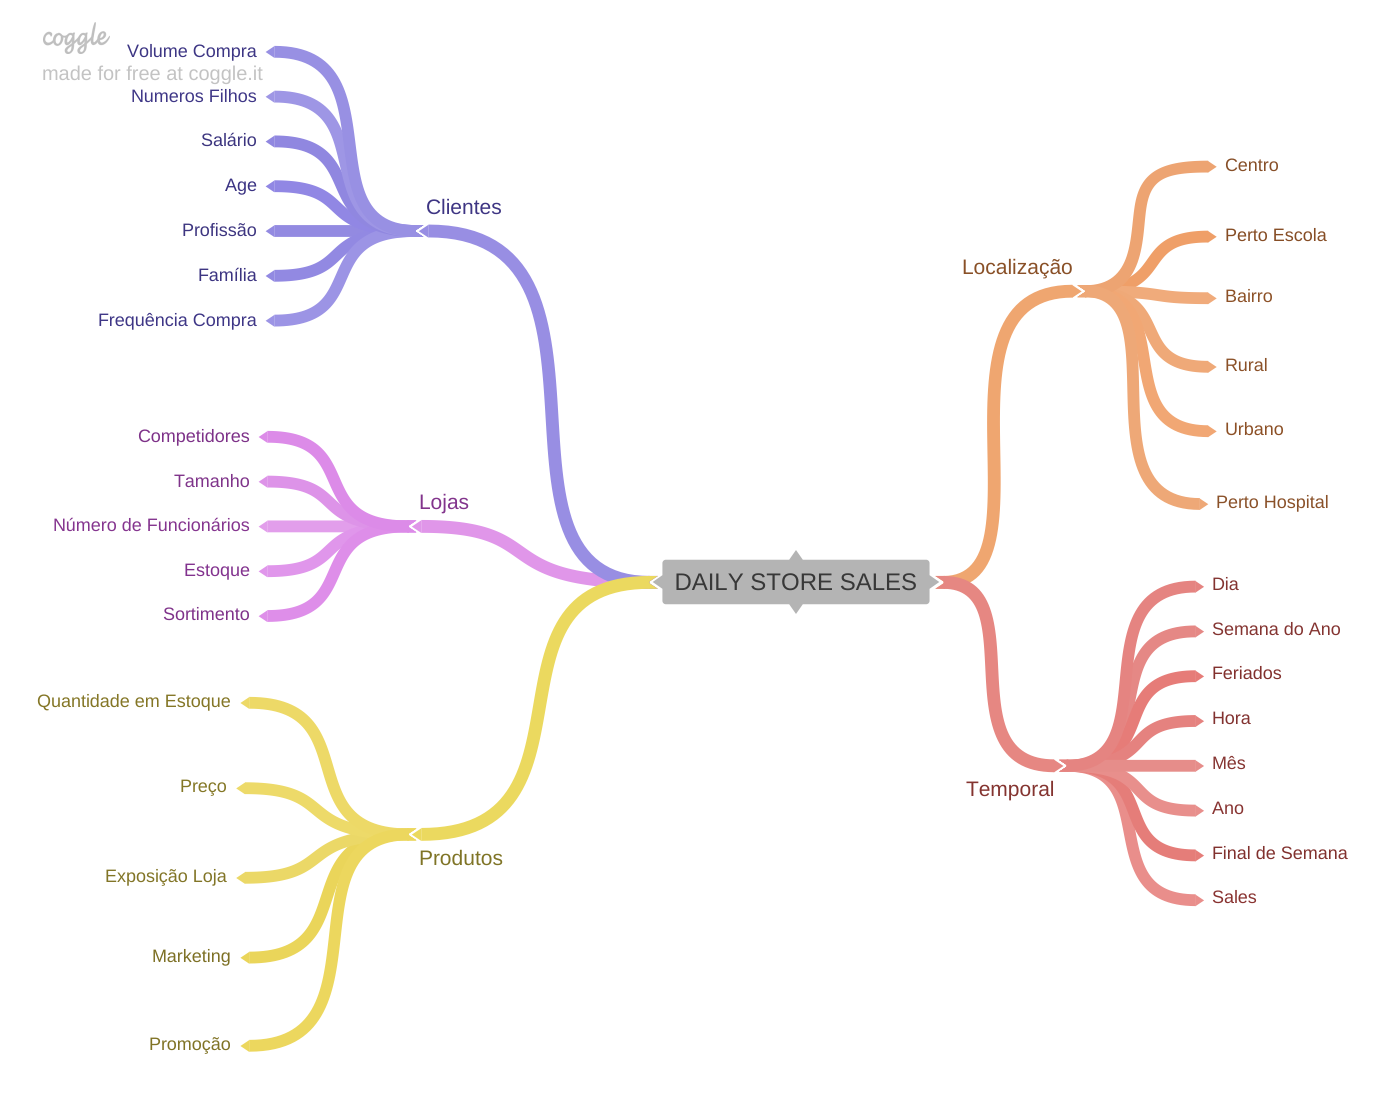

In [25]:
Image('/Users/diasn/projetos/DataScienceEmProducao/image/daily_store.png')

## 2.2. Creating Hypotheses

*Hypotheses about Stores*

**1.** Store with more employees should sell more.

**2.** Store with greater inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Store with larger assortments should sell more.

**5.** Store with closer competitors should sell less.

**6.** Stores with longer competitors can sell more.


*Hyphoteses about Products*

**1.** Stores that invest more in marketing should sell more.

**2.** Store with greater product exposure should sell more.

**3.** Store with low-priced products are expected to sell more.

**4.** Store with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with active promotions for longer should sell more.

**6.** Stores with more promotion days can sell more.

**7.** Stores with more consecutive promotions should sell more.

*Hyphoteses about Time* 

**1.** Stores that open on Christmas should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.



## 2.3. Hyphoteses Final List 

**1.** Store with larger assortments should sell more.

**2.** Store with closer competitors should sell less.

**3.** Stores with longer competitors can sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days can sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores that open on Christmas should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.


## 2.4. Featuring Engineering

With the hypotheses mindmap proposal, we will create some variables in dataset to facilite the exploration of the dataset in the EDA phase as:

In [26]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [27]:
#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                 month = x['competition_open_since_month'], day= 1), axis = 1)

In [28]:
#competition time month
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

In [29]:
#transformation the columns in strings
#df2['promo2_since_year'] = df2['promo2_since_year'].astype(str) 
#df2['promo2_since_week'] = df2['promo2_since_week'].astype(str)

#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') 
                                              - datetime.timedelta(days = 7) )

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/ 7).apply(lambda x: x.days).astype(int)

In [30]:
#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                  if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [31]:
#checking the featuring engineering
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. STEP 03 - VARIABLE FILTERING

In [32]:
#copy dataset
df3 = df2.copy()

In this step 03, we will go to make the variable filtering. The motivation for this are business restrics.

## 3.1. Row Filtering 

We're going to filter the rows first, because the performance is better when fltering the columns later. There are less data to process.

As it makes no sense to get data from closed stores (open = 0), we'll consider only the rows where open = 1 which is the same as saying 'open' != 0.

As closed stores have 0 sales, we'll consider only the sales from open stores (open = 1), that is, 'sales' > 0.

In [33]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Column Selection

We don't have the number of customers at the moment of the prediction. We would need other ML model to predict it and use it here. The scope of this project will not consider the customers, so we'll classify it as a business restriction.

In the previous step, as we filtered only the rows where open = 1, it makes no sense to keep the column open because it has only values equal to 1.

Also, the columns promo_interval and month_map were only used to derive other columns. Thus, we don't need them anymore.

In [34]:
# drops the columns
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [35]:
#checking columns
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

Before starting the exploratory data analysis, let's make a copy of the data set. It is important to not miss, if it happens, what has been done so far.

In [36]:
#copy dataset df3
df4 = df3.copy()

In [37]:
#checking dataset df4
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In summary, the importance of exploratory data analysis is to understand how the variables impact the phenomenon. And from there, measure the strength of that impact. So, the three objectives of the EDA are:

- Gain business experience.

- Validate business hypotheses.

- Understand which variables are important to the business.

We will make three types of the Analysis: Univariate Analysis, Bivariate Analysys and Multivariate Analysis.

## 4.1. Univariate Analysis

### 4.1.1. Target Variable

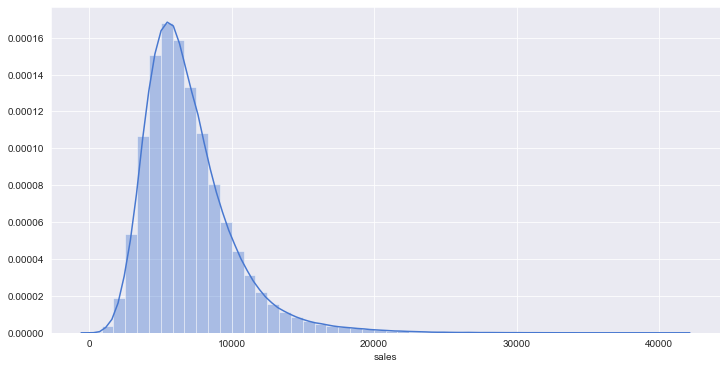

In [38]:
sales = sns.distplot(df4['sales']);

sales.figure.set_size_inches(12,6)

plt.show()


How we can analyse, the sales distribution is an asymmetric curve, that is,it's a curve that not follow a normal distribution.

The Machine Learning algorithms require that data follow a normal distribution because their constructions are based on a continuous probability distribution. When the data not follow a normal distribution, we can apply techniques. 

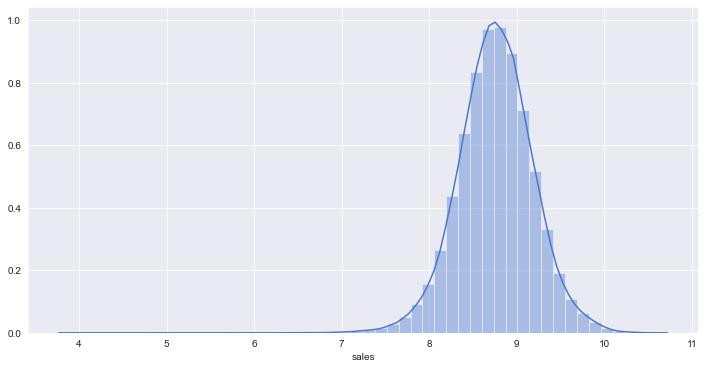

In [39]:
#distribution plotting for 'sales'
#applies log(x+1) to 'sales'

sales = sns.distplot(np.log1p(df4['sales']))

sales.figure.set_size_inches(12,6)

plt.show()

### 4.1.2. Numerical variable

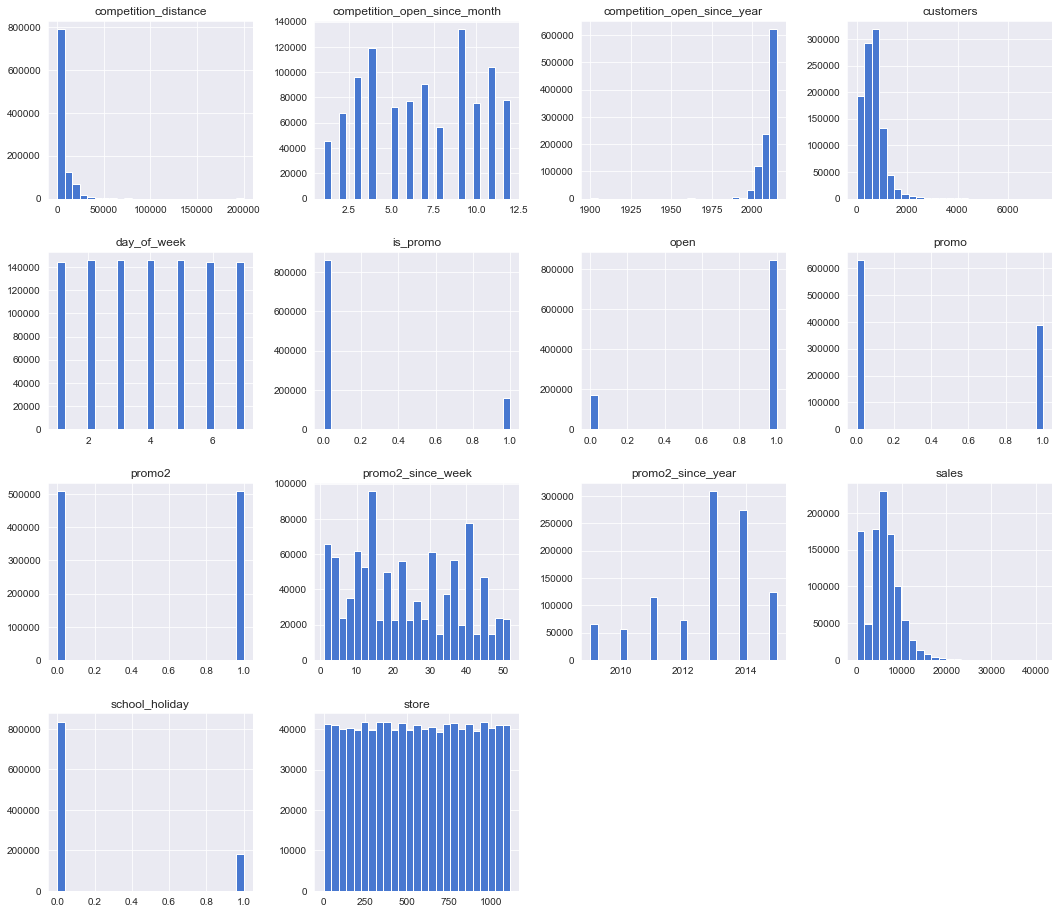

In [40]:
# sets the figure size
fig = plt.figure(figsize = (18,16))

#sets axes
ax = fig.gca()

#plot histograms
num_attributes.hist(ax = ax, bins=25);

Analyzing the histograms, we have:

**Competition Distance:** We can see that competitiors meet in a range of 0 to 50000.

**Competition Open Since Month:** We can see that there is an increase in competition in the first months. Then in the months of May to August there is a drop / stability. And finally, in the months of September to December there is an increase and a decrease. This generates seasonality.

**Competition Open Since Year**: we can see that the competitions of open stores had an increasing increase since the 2000s. But in 2015 the number of competitions was very high.

**Customers**: We can see that the number of customers per day for the first 1000 days is higher. But then, the number of customers drops considerably.

**Day of Week**: We can see that the histogram have a uniform distribution, is that, the stores open every day of the week. 

**Is Promo**: We can see that many stores are not in promotion (promo=0) than in promotion (promo=1).

**Open**: We can see that there many stores open (open=1) than closed (open=0). This result may be influenced by stores that open on holidays.

**Promo**: we can see that there are many more stores that weren't in regular promotion (promo=0) than those who were (promo=1).

**Promo2**: we can see that there is a tie between stores that participated in promo2 and stores that did not participate in promo2.

**Promo2 Since Week**: we can observe that the graph does not present an immediate conclusion. We have that analise more.

**Promo2 Since Year**: We can observe that many stores participed of the promotion in the years 2013 and 2014.

**Sales**: we can see that there were many more sales ranging from 0 to nearly 10,000.

**School Holiday**: we can see that there many more stores that were not affected by the closure of publics schools.

**Stores**: The stores variable describe a unique Id for each store. Therefore, in this graph there is nothing to extract. 


### 4.1.3. Categorical Variable

In [41]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [42]:
# checks unique values for 'state_holiday' we have in the dataset
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [43]:
#checks unique values for 'state_holiday'
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

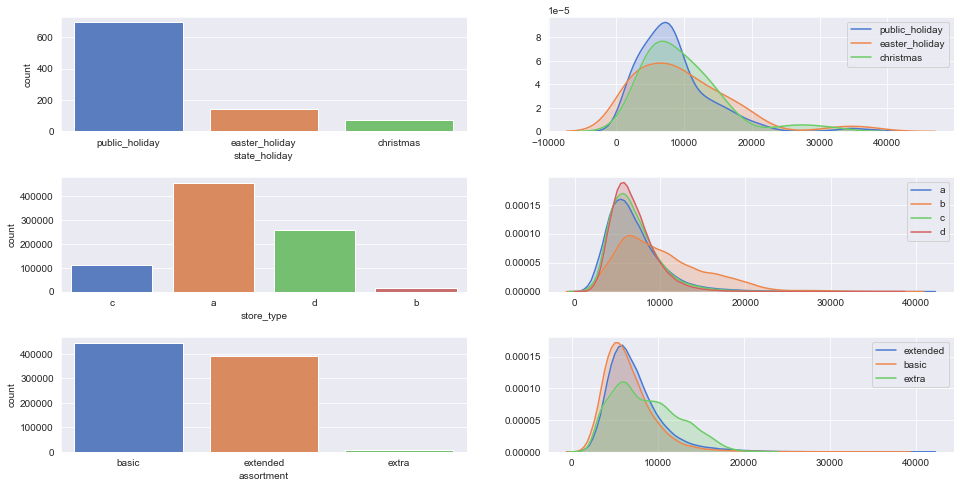

In [44]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# state_holiday
plt.subplot(3,2,1)
df_no_regular_day = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(df_no_regular_day['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.4)

# display plots
plt.show()

# 4.2. Bivariate Analysis

In [45]:
#checking dataset
df4

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,9,2006,0,1,2013,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,10,1999,0,1,2013,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,1,2013,1,48,2012,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,1,2013,0,1,2013,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


We make the bivariate analysis of the hyphoteses final list. Therefore, follow that

### **H1. Store with larger assortments should sell more**

*FALSE Store larger assortment sells less*.

In [46]:
#Assortment, Sales
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

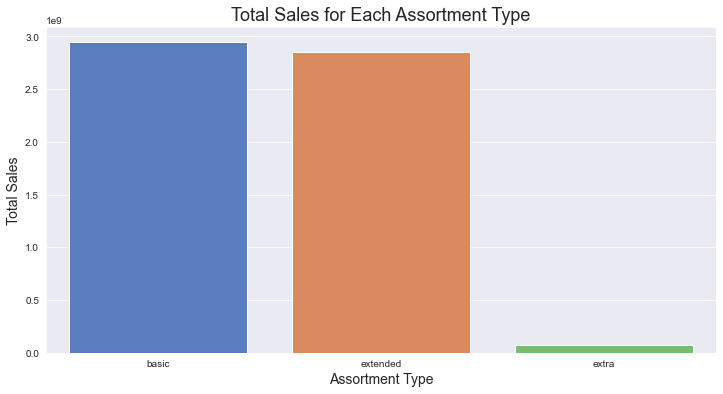

In [47]:
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12,6)

ax = sns.barplot(x = 'assortment', y ='sales', data = aux1)

#sets the title and axis labels
set_plots_features(ax, 'Total Sales for Each Assortment Type', 'Assortment Type', 'Total Sales' )

#display the plot
plt.show()

Assuming that largest assortments are of the extra type and analyzing the barplot, we find that sales of extra assortments are small compared to the basic and extended types. Therefore, we can conclude that **stores with larger assortments sell less**.

However, we can ask ourselves if there has been any change in sales behavior over time. For this, we will check the **sales** for each assortment during the **weeks of the years**.

In [48]:
#check each assortment sales
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693
...,...,...,...
406,2015-29,extended,19570832
407,2015-29,extra,574020
408,2015-30,basic,23492454
409,2015-30,extended,23301780


In [49]:
#create a pivot table
aux3 = aux2.pivot(index='year_week', columns = 'assortment', values='sales')
aux3

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061
...,...,...,...
2015-26,27840342,27165959,684180
2015-27,20356210,20449036,586036
2015-28,25746704,25629698,632017


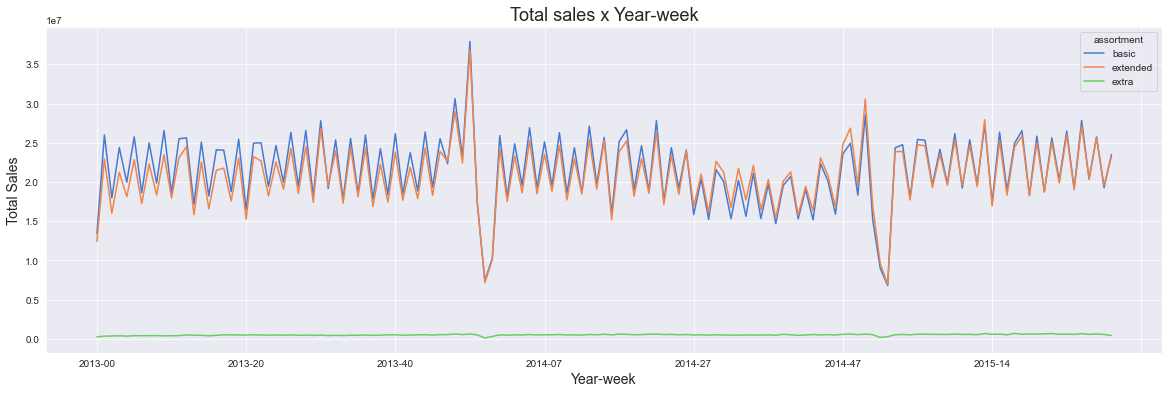

In [50]:
#plot a lineplot for 'aux3'
ax = aux3.plot()

#set the figure size in inches
ax.figure.set_size_inches(20,6)

#set the title and axis labels
set_plots_features(ax, 'Total sales x Year-week','Year-week','Total Sales' )

#displays the plot
plt.show()

Looking at the graph above, we can conclude that the sales of the basic and extended assortment types are practically the same over time. But, we need verify the line that describe teh sales behavior of the extra type assortment. Therefore,

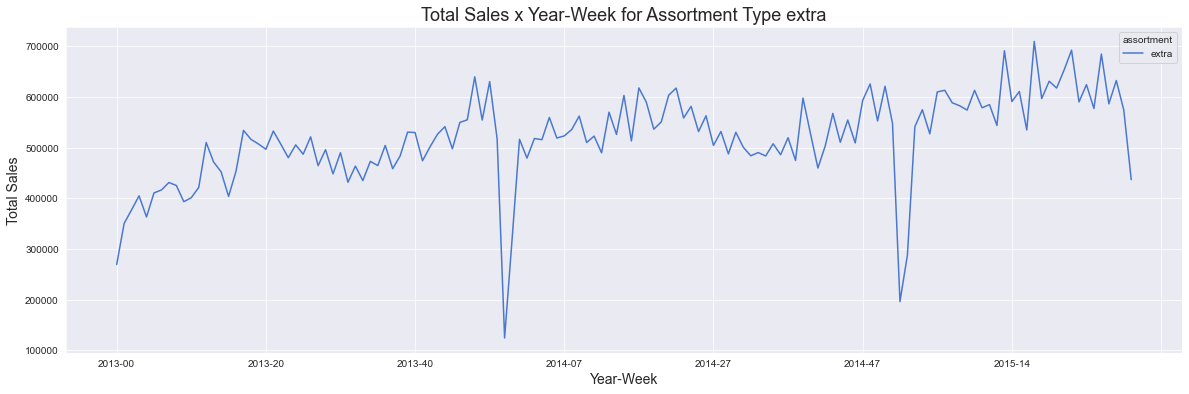

In [51]:
aux4 = aux2[aux2['assortment'] == 'extra']

ax = aux4.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

#sets the figure size in inches
ax.figure.set_size_inches(20,6)

#sets the title and axis labels
set_plots_features(ax, 'Total Sales x Year-Week for Assortment Type extra', 'Year-Week', 'Total Sales')

#displays the plot
plt.show()


Looking at the line graphs, we can see if the stores with the largest (extra) assortment have the least sales.

Therefore, the hyphotesis is **FALSE**

### **H2. Store with closer competitors should sell less**

*FALSE Store with closer competitors sell more*

In [52]:
#checks total sales for each 'competition distance'
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
aux1

,competition_distance,sales
0,20.0,4579807
1,30.0,17552666
2,40.0,29261626
3,50.0,60835848
4,60.0,22088359
...,...,...
650,46590.0,3554993
651,48330.0,3798660
652,58260.0,5718883
653,75860.0,6896821


In [53]:
#create bins that range 0 to 20000 with steps of 1000
bins = list(np.arange(0, 20000, 1000))

#places the data in the bins
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)

aux1.sample(10)

,competition_distance,sales,competition_distance_binned
312,4210.0,5367788,"(4000, 5000]"
81,850.0,11824159,"(0, 1000]"
253,3160.0,4365642,"(3000, 4000]"
51,530.0,2845461,"(0, 1000]"
419,7290.0,7300878,"(7000, 8000]"
207,2390.0,6843911,"(2000, 3000]"
316,4300.0,3960984,"(4000, 5000]"
516,12770.0,7317626,"(12000, 13000]"
230,2820.0,7375962,"(2000, 3000]"
216,2540.0,3465390,"(2000, 3000]"


In [54]:
#get the total sales for each bin
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
aux2

,competition_distance_binned,sales
0,"(0, 1000]",1832415839
1,"(1000, 2000]",918682669
2,"(2000, 3000]",610405362
3,"(3000, 4000]",378745560
4,"(4000, 5000]",325665741
5,"(5000, 6000]",218735915
6,"(6000, 7000]",168769215
7,"(7000, 8000]",133211838
8,"(8000, 9000]",180027950
9,"(9000, 10000]",121250715


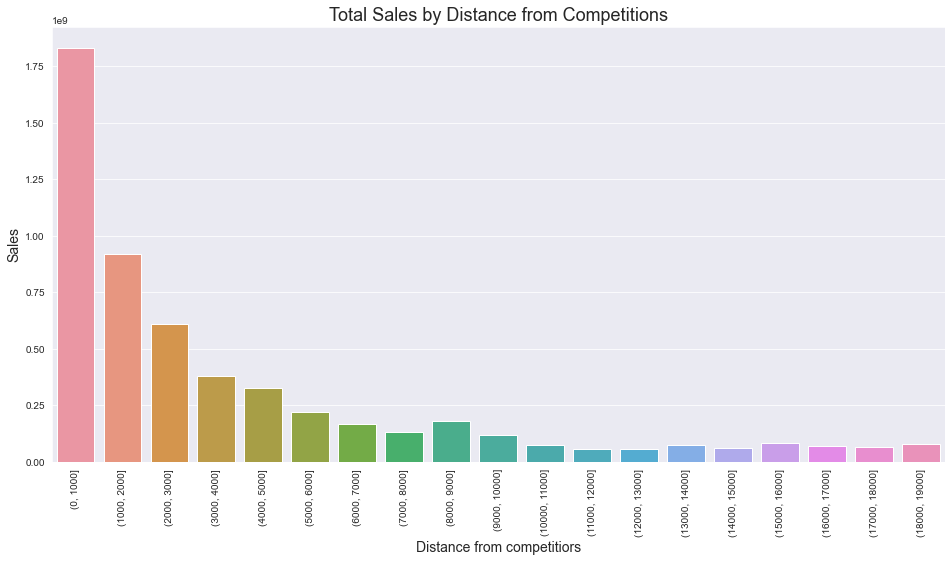

In [55]:
#uses the variable ax for single a Axes
fig, ax = plt.subplots()

#sets the figure size in inches 
ax.figure.set_size_inches(16,8)

#plot a barplot
ax = sns.barplot(x='competition_distance_binned', y = 'sales', data = aux2)

#rotates labels
plt.xticks(rotation = 90)

#sets the title and axis labels 
set_plots_features(ax ,'Total Sales by Distance from Competitions','Distance from competitiors', 'Sales')

#displays the plot
plt.show()

Observing the results, stores with closer competitors sell more. Therefore, the hyphotese is **FALSE**.

We can also plot a scatter plot to verify this result. 

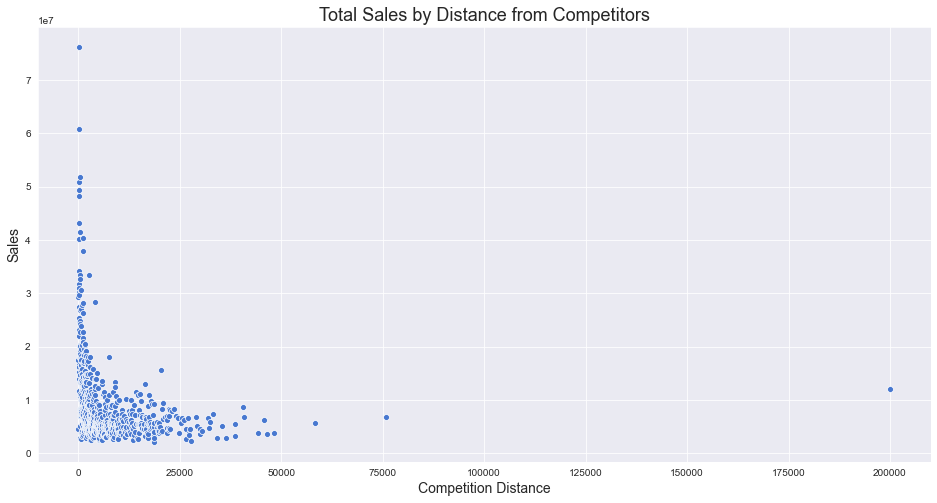

In [56]:
#check total sales for each 'competition_distance'
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#uses the variable ax for single a Axes
figure, ax = plt.subplots()

#sets the figure size in inches 
ax.figure.set_size_inches(16,8)

#plots a scatter plot for sales in relation to competition_distance
ax = sns.scatterplot(x='competition_distance', y = 'sales', data = aux1)

#title and axis labels
set_plots_features(ax, 'Total Sales by Distance from Competitors', 'Competition Distance', 'Sales')

#displays the plot
plt.show()

On the scatter plot, the concentration of the points of sale occurs in stores with closer competitors. This also confirms the hypothesis is **FALSE**.

**Organizand the plots in a single grid**

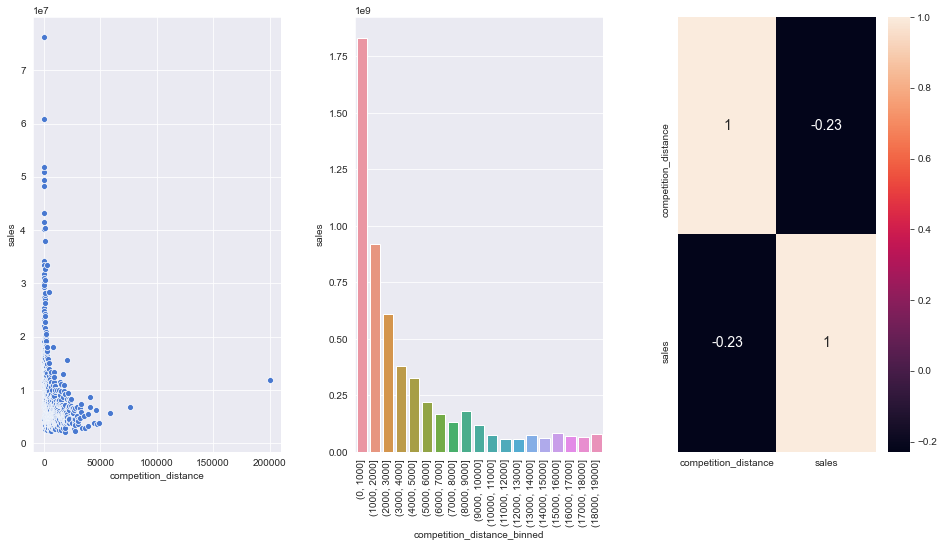

In [57]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a scatter plot
plt.subplot(1, 3, 1)
ax = sns.scatterplot(x='competition_distance', y='sales', data=aux1)


# plots a bar plot
plt.subplot(1, 3, 2)
ax = sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

# rotates xlabels
plt.xticks(rotation = 90)


# plots a heatmap
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# adjusts the width spaces between plots
plt.subplots_adjust(wspace = 0.3)

# displays the plots
plt.show()

Reggarding Pearson's correlation, we can see that the result of **-0,23** is a **weak negative correlation**. This explains that the further away the competitions are, the lower the store sales will be.

### **H3. Stores with longer competitions can sell more**

*FALSE Stores with longer competitions sell less*

In [58]:
#gets all sales by months since the a competition store opened
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

#gets only the 120 months AND opened in the same month of the sale 
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

aux2

,competition_time_month,sales
0,-32,198200
1,-31,993663
2,-30,2232685
3,-29,3175827
4,-28,4157527
...,...,...
147,115,15655375
148,116,15784105
149,117,15658505
150,118,14428150


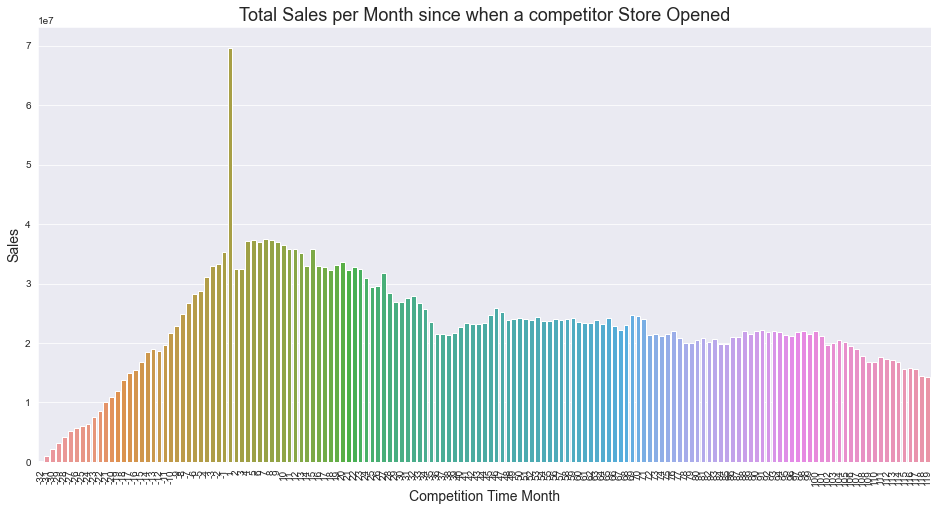

In [59]:
# uses variable ax for single a Axes
fig, ax = plt.subplots()

#sets the figure size in inches
ax.figure.set_size_inches(16,8)

#plot a barplot
ax = sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)

#rotates the xticks
plt.xticks(rotation = 90)

#title and axis labels
set_plots_features(ax, 'Total Sales per Month since when a competitor Store Opened', 'Competition Time Month', 'Sales')

#display plot
plt.show()

Analyzing the barplot, we can see that the more negative values approach 0, the sales are higher. What does that mean ?
Means that stores with recent competitions sell more. On the other hand, stores with longer competitions sell less.
Therefore, the hypothesis is **FALSE**.

Let's plots the Pearson's correlation according to the code.

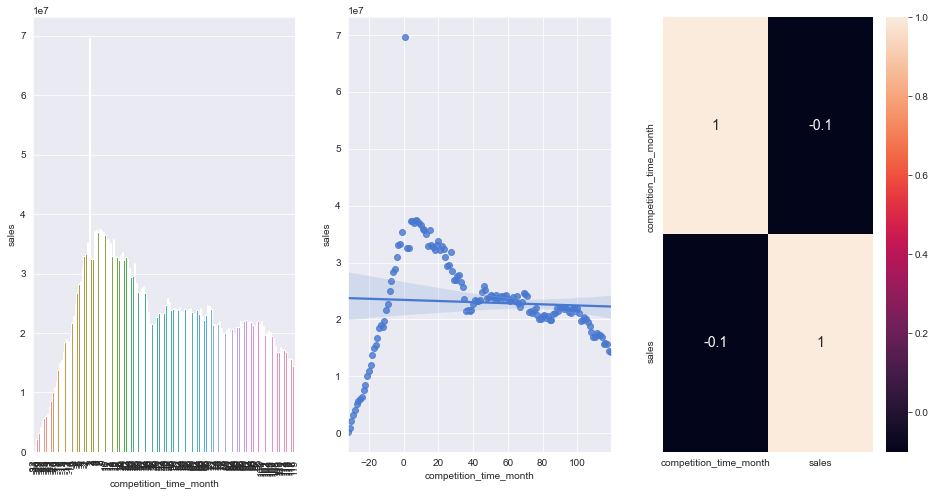

In [60]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot
plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2)

# rotates the xticks
plt.xticks(rotation=90)

# plots a regplot
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

# plots a heatmap
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plot
plt.show()

The Pearson's correlation is weak negative because your result is **-0,10**. But, this result is important because it influences the variable response which is sales. On the other hand, is necessary to use another type of correlation to measure the dispersion of the points and error. 

### **H4. Stores with active promotions for longer should sell more**

*FALSE Stores with active promotions for longer sell less*

In [61]:
# gets total sales based on how long a promotion was active
aux = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
aux

,promo_time_week,sales
0,-126,80706
1,-125,147212
2,-124,107127
3,-123,140121
4,-122,116593
...,...,...
435,309,360433
436,310,277156
437,311,353546
438,312,268970


### Reading of the table above

1) promo_time_week > 0: sales made inside the **extended** promotion time.

2) promo_time_week < 0: sales made inside the **regular** promotion time.


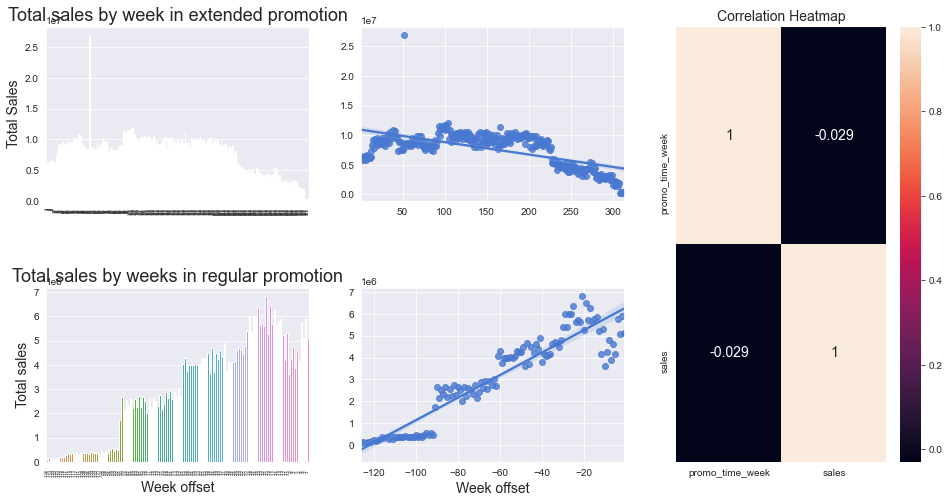

In [62]:
from matplotlib.gridspec import GridSpec

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

grid = GridSpec(2, 3)

# adjusts the space between subplots
plt.subplots_adjust(hspace = 0.5)

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

#gets the extended promo data
aux1 = aux[aux['promo_time_week'] > 0]

#plot a barplot
plt.subplot(grid[0,0])
ax1 = sns.barplot(x='promo_time_week', y = 'sales', data = aux1);

#sets the title and axis labels
set_plots_features(ax1, "Total sales by week in extended promotion", " ", "Total Sales")

#rotates the xticks
plt.xticks(rotation = 90, fontsize = 4);

#plot a regplot
plt.subplot(grid[0,1])
ax2 = sns.regplot(x ='promo_time_week', y ='sales', data=aux1)

#set the title and axis labels
set_plots_features(ax2," ", " ", " ")

#gets the regular promo data
aux2 = aux[aux['promo_time_week'] < 0]


#plot a barplot
plt.subplot(grid[1,0])
ax3 = sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);

# sets the title and axis labels
set_plots_features(ax3, "Total sales by weeks in regular promotion", "Week offset", "Total sales")

# rotates the xticks
plt.xticks(rotation=90, fontsize=4)

#plot a regplot
plt.subplot(grid[1,1])
ax4 = sns.regplot(x ='promo_time_week', y ='sales', data=aux2)

# sets the title and axis labels
set_plots_features(ax4, " ", "Week offset", " ")

# plots correlation heatmap
plt.subplot(grid[:,2])
ax5 = sns.heatmap(aux.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# sets the title
ax5.set_title("Correlation Heatmap", fontsize=14)

# displays the plot
plt.show()

As we can see in the total sales x weeks in extended promotion, there is a period when the extended promotion results in more sales. After a period of time, total sales begin to decline.

From the total sales x weeks in regular promotion, we can see that, as compensation gets closer to zero, sales start to increase.

Therefore, stores with a longer promotion period do not have higher sales. The hypothesis is **FALSE**.

In relation the correlation heat map, we obtained a coeficient of **-0,029** which is very close to zero. Therefore, we have a super weak correlation. This is result makes sense because it has sales that are often constant over time.

So, maybe we won't include promo_time_week in the model. Of course, this variable might work if we combine it with another variable, but we'll leave it for the time being.

### <s>**H5. Stores with more promotion days can sell more**</s>

As this hypothesis similar to H4. We will leave to validate it in the next CRISP cycle.

###  **H6. Stores with more consecutive promotions should sell more**

*FALSE Stores with more consecutive promotions sell less*

In [63]:
#gets total sales made based on promotion and consecutive promotions
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


Looking at the results, there were more sales when there was only one promotion (promotion = 1 AND promo2 = 0) than when there were consecutive promotions (promotion = 1 AND promo2 = 1).

In [64]:
# gets all rows in which there were consecutive promotions
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1

,year_week,sales
0,2013-01,20995409
1,2013-03,19481514
2,2013-05,20580811
3,2013-07,20273185
4,2013-09,21451952
...,...,...
67,2015-22,21069133
68,2015-24,22839486
69,2015-26,23972605
70,2015-28,21867757


In [65]:
# gets all rows in which there weren't consecutive promotions
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2

,year_week,sales
0,2013-01,22118270
1,2013-03,20567037
2,2013-05,22087889
3,2013-07,21631750
4,2013-09,22727171
...,...,...
67,2015-22,23590590
68,2015-24,23635449
69,2015-26,25394352
70,2015-28,23393262


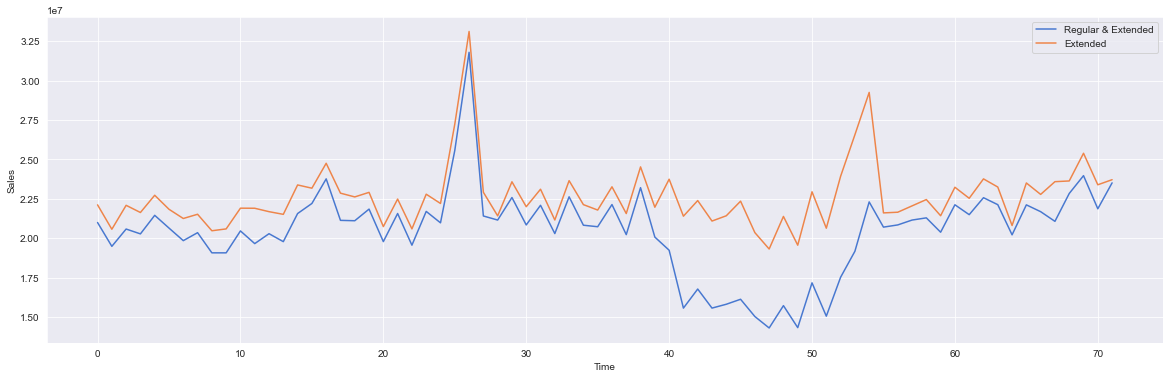

In [66]:
#plots a lineplot
ax = aux1.plot()

#plots in the same grid
aux2.plot(ax = ax)

#sets the figure size in inches
ax.figure.set_size_inches(20,6)

#sets the legend
ax.legend(labels=['Regular & Extended', 'Extended']);
plt.xlabel('Time')
plt.ylabel('Sales')

#display the plot
plt.show()

Looking at the results it seems that stores with more consecutive promotions sell less. Therefore, the hypothesis is **FALSE**.

Regarding the relevance of the promo2 variable to the ML model, we can say that its relevance is low.

### **H7. Stores that open on Christmas should sell more**

*FALSE Stores that open on Christmas sell less*

In [67]:
#gets only the holidays excluding the regular days
aux1 = df4[df4['state_holiday'] != 'regular_day']

#getting the total sales by state holiday
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux2

,state_holiday,sales
0,christmas,691806
1,easter_holiday,1433744
2,public_holiday,5890305


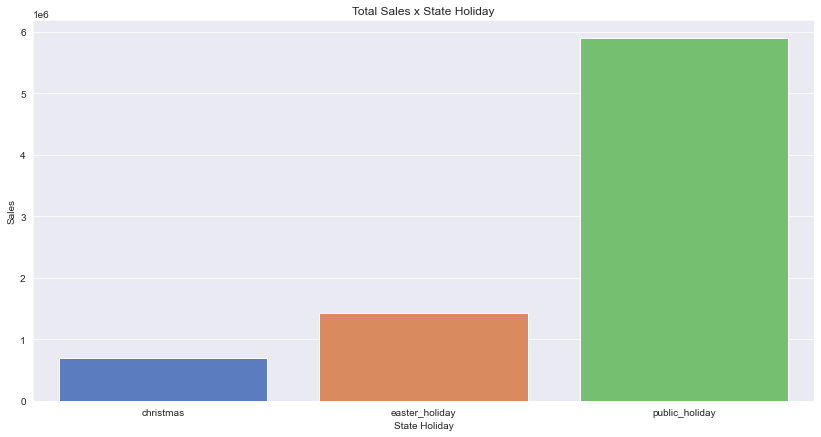

In [68]:
#uses the variable ax for single a Axes
fig, ax = plt.subplots()

#sets the figure size in inches
ax.figure.set_size_inches(14,7)

#plot a barplot for total sales in relation state holiday
sns.barplot(x ='state_holiday', y ='sales', data = aux2)

#title
plt.title('Total Sales x State Holiday')
plt.xlabel('State Holiday')
plt.ylabel('Sales')

#display plot 
plt.show()

In [69]:
#gets total sales by year and state holiday
aux3 = aux1[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
aux3

,year,state_holiday,sales
0,2013,christmas,331182
1,2013,easter_holiday,454997
2,2013,public_holiday,2052408
3,2014,christmas,360624
4,2014,easter_holiday,463353
5,2014,public_holiday,2084616
6,2015,easter_holiday,515394
7,2015,public_holiday,1753281


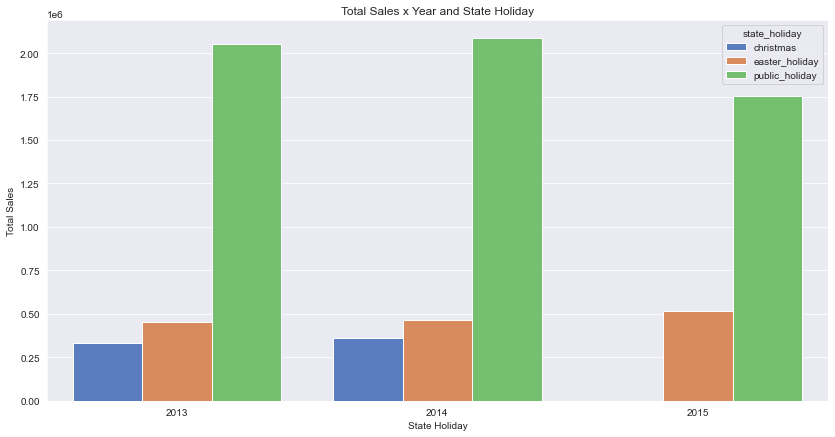

In [70]:
#uses the variable ax for single a Axes
fig, ax = plt.subplots()

#sets the figure size in inches
ax.figure.set_size_inches(14,7)

#plots a barplot for total sales by state holiday
sns.barplot(x ='year', y ='sales', hue = 'state_holiday', data = aux3)

#title and axis labels
plt.title('Total Sales x Year and State Holiday')
plt.xlabel('State Holiday')
plt.ylabel('Total Sales')

#display plot 
plt.show()

As noted in the previous results, stores that open on Cristmas sell less. Therefore, the hypothesis is **FALSE**.

One observation we need to make here is that, in 2015, we still don't have Christmas sales data, because the data ends on July 31, 2015.

Maybe we can consider this relevant variables for the Machine Learning model beause we have changes in sales depending on the type of holiday state and in what year.

### **H8. Stores should sell more over the years**

*FALSE Stores sell less over the years.*

In [71]:
#gets the total sales by year
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()
aux

,year,sales
0,2013,2302876084
1,2014,2180804896
2,2015,1389499643


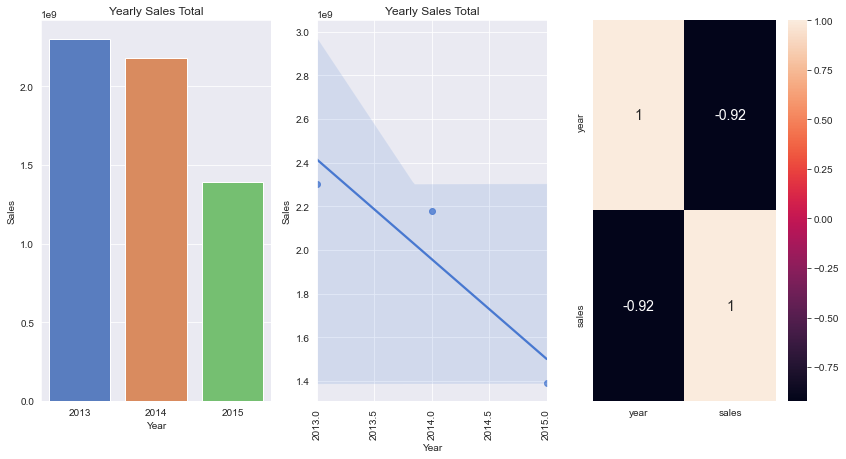

In [72]:
#uses the variable ax for single a Axes
fig, ax = plt.subplots()

#sets the figure size in inches
ax.figure.set_size_inches(14,7)

#plots a barplot for total sales by year
plt.subplot(1, 3, 1 )
ax = sns.barplot( x = 'year', y = 'sales', data = aux)

#title and axis labels
plt.title('Yearly Sales Total')
plt.xlabel('Year')
plt.ylabel('Sales')

# plots a barplot for total sales by year
plt.subplot(1, 3, 2)
ax = sns.regplot(x='year', y='sales', data=aux)

# sets the title and axis labels
plt.title('Yearly Sales Total')
plt.xlabel('Year')
plt.ylabel('Sales')

# rotates xticks labels
plt.xticks(rotation=90)


# plots a heatmap
plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plot
plt.show()

As noted in the previous results, stores sell less over the years. In addition, looking at the Pearson correlation coefficient of -0.92, we can see that there is a strong negative correlation between year and sales. So, the hypothesis is FALSE.

### H9. Stores should sell more in the second half of the year

*FALSE Stores sell less in the second half of the year.*

In [73]:
#gets the total sales by month 
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()
aux

,month,sales
0,1,566728724
1,2,528734410
2,3,599831906
3,4,575895295
4,5,569248217
5,6,578112775
6,7,595059205
7,8,361791202
8,9,342570131
9,10,351878728


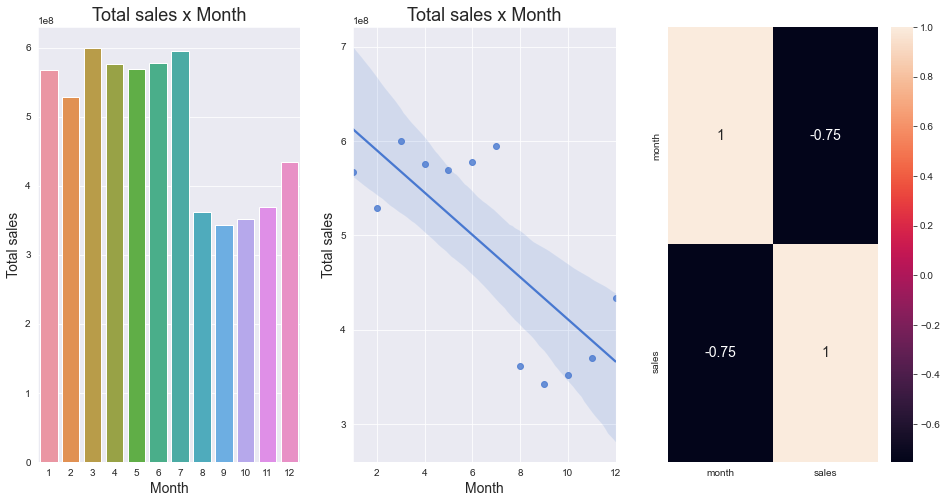

In [74]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by month
plt.subplot(1, 3, 1)
ax = sns.barplot(x='month', y='sales', data=aux)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Month", "Month", "Total sales")


# plots a barplot for total sales by month
plt.subplot(1, 3, 2)
ax = sns.regplot(x='month', y='sales', data=aux)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Month", "Month", "Total sales")


# plots a barplot for total sales by month
plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plots
plt.show()

As noted in the previous results, stores sell less in the second half of the year. In addition, by looking at Pearson's correlation coefficient of -0.75, we can see if there is a strong negative correlation between month and sales, which means that the sales fall over time.

### H10. Stores should sell more after the 10th of each month

*TRUE Stores sell more after the 10th of each month*

In [75]:
#gets the total sales by before and after the 10th day of the month
aux = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux

,day,sales
0,1,155983560
1,2,233513169
2,3,194582812
3,4,228301010
4,5,212869176
5,6,197094539
6,7,201380487
7,8,189718770
8,9,175922427
9,10,181039363


In [76]:
#classifies which day is before and after the 10th day of the month
df4['before_after'] = df4['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

#gets the total sales by before and after the 10th day of the month
aux1 = df4[['before_after', 'sales']].groupby('before_after').sum().reset_index()

aux1

,before_after,sales
0,after_10_days,3902775310
1,before_10_days,1970405313


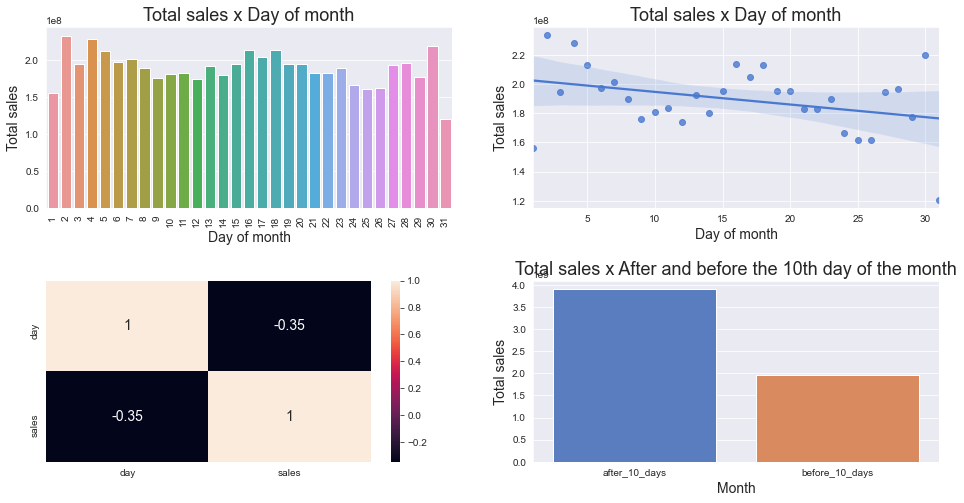

In [77]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by day
plt.subplot(2, 2, 1)
ax = sns.barplot(x='day', y='sales', data=aux)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Day of month", "Day of month", "Total sales")

# rotates the xticks
plt.xticks(rotation=90)

# plots a barplot for total sales by day
plt.subplot(2, 2, 2)
ax = sns.regplot(x='day', y='sales', data=aux)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Day of month", "Day of month", "Total sales")


# plots a barplot for total sales by day
plt.subplot(2, 2, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})


# plots a barplot for total sales by before and after the 10th day of the month
plt.subplot(2, 2, 4)
ax = sns.barplot(x='before_after', y='sales', data=aux1)

# sets the title and axis labels
set_plots_features(ax, "Total sales x After and before the 10th day of the month", "Month", "Total sales")

# adjusts the vertical space between plots
plt.subplots_adjust(hspace = 0.4)

# displays the plots
plt.show()

As observed in the previous results, stores sell more after the 10th day of the month. Therefore, the hypothesis is **TRUE**.

In addition, checking the Pearson's correlation coefficient, we got a value of -0.35 which tells us that is a no so strong correlation between day and sales. However, as we have different values for total sales before and after the 10th day of the month, this variable can be relevant for our ML Model.

### H11. Stores should sell less on weekends

*TRUE Stores sell less on weekends.*

In [78]:
#gets the total sales by day_of_week
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

aux

,day_of_week,sales
0,1,1130203012
1,2,1020411930
2,3,954962863
3,4,911177709
4,5,980555941
5,6,846317735
6,7,29551433


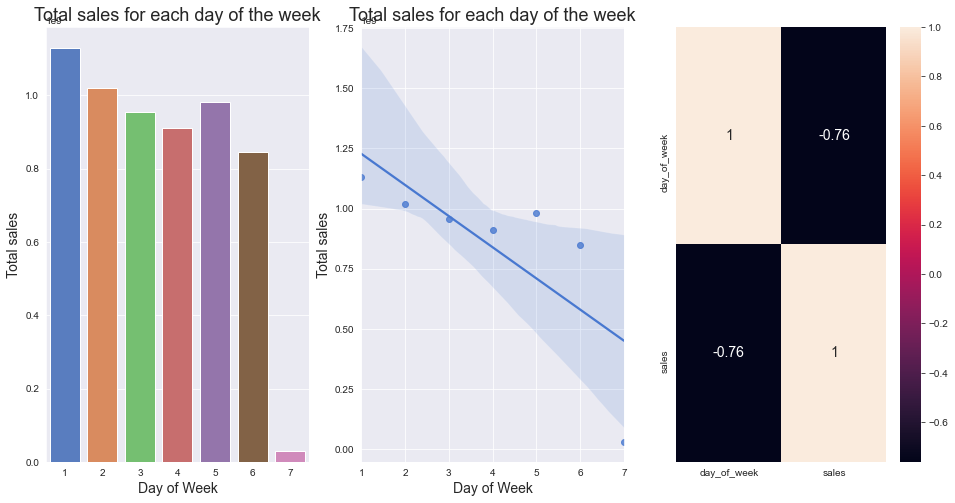

In [79]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by day_of_week
plt.subplot(1, 3, 1)
ax = sns.barplot(x='day_of_week', y='sales', data=aux)

# sets the title and axis labels
set_plots_features(ax, "Total sales for each day of the week", "Day of Week", "Total sales")


# plots a barplot for total sales by day_of_week
plt.subplot(1, 3, 2)
ax = sns.regplot(x='day_of_week', y='sales', data=aux)

# sets the title and axis labels
set_plots_features(ax, "Total sales for each day of the week", "Day of Week", "Total sales")

# plots a barplot for total sales by day_of_week
plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plots
plt.show()

As noted in previous results, stores sell less on weekends. In addition, looking at Pearson's correlation coefficient of -0.76, we can see that there is a strong negative correlation between day of the week and sales.

There, the hypothesis is **TRUE**

### H12. Stores should sell less during school holidays

*TRUE Stores sell less during school holidays*

In [80]:
#gets the total sales by school holidays
aux = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

aux

,month,school_holiday,sales
0,1,0,490739687
1,1,1,75989037
2,2,0,476170426
3,2,1,52563984
4,3,0,529719808
5,3,1,70112098
6,4,0,432131835
7,4,1,143763460
8,5,0,523512599
9,5,1,45735618


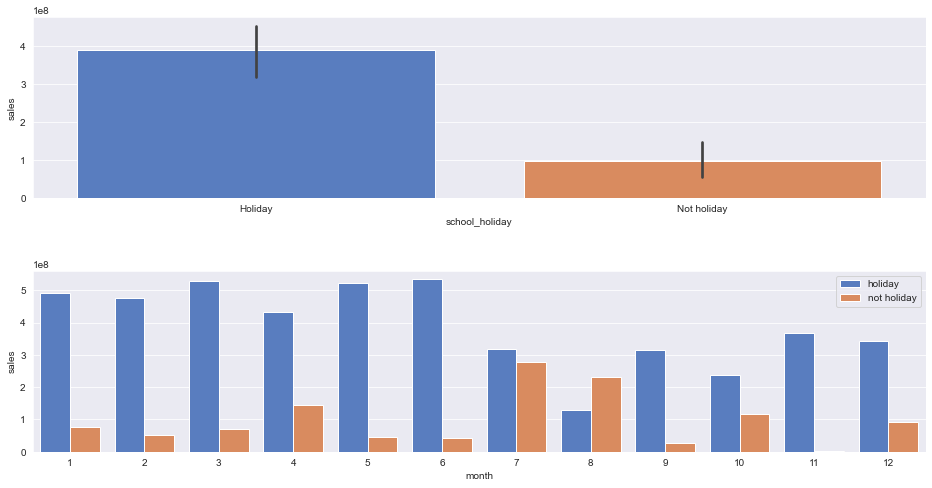

In [81]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by school_holiday
plt.subplot(2, 1, 1)
ax = sns.barplot(x='school_holiday', y='sales', data=aux)

# sets xticks labels
ax.set_xticklabels(['Holiday','Not holiday'])

# plots a barplot for total sales by month and school_holiday
plt.subplot(2, 1, 2)
ax = sns.barplot(x='month', y='sales', hue='school_holiday', data=aux)

# sets legend
labels = ['holiday','not holiday']
h, _ = ax.get_legend_handles_labels()
ax.legend(h, labels)

# adjusts the vertical space between plots
plt.subplots_adjust(hspace = 0.4)

# displays the plots
plt.show()

As noted in the previous results, stores sell less during school holidays, except in July (7) and August (8). Therefore, this hypothesis is **TRUE**.

### 4.2.1. Hypothesis Summary

In [82]:
tab = [
    ['Hypothesis','Conclusion','Relavance to ML model'],
    ['H1','False','Low'],
    ['H2','False','Medium'],
    ['H3','False','Medium'],
    ['H4','False','Low'],
    ['H5','--','--'],
    ['H6','False','Low'],
    ['H7','False','Medium'],
    ['H8','False','High'],
    ['H9','False','High'],
    ['H10','True','High'],
    ['H11','True','High'],
    ['H12','True','Low'] 
]

print(tabulate(tab, headers = 'firstrow'))

Hypothesis    Conclusion    Relavance to ML model
------------  ------------  -----------------------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            --            --
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3. Multivariate Analysis

In this section we'll check the correlations between the explanatory variables, separating the analysis for numerical attributes and categorical attributes.

### 4.3.1. Numerical Attributes

In [83]:
#checks the numerical attributes dataset
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


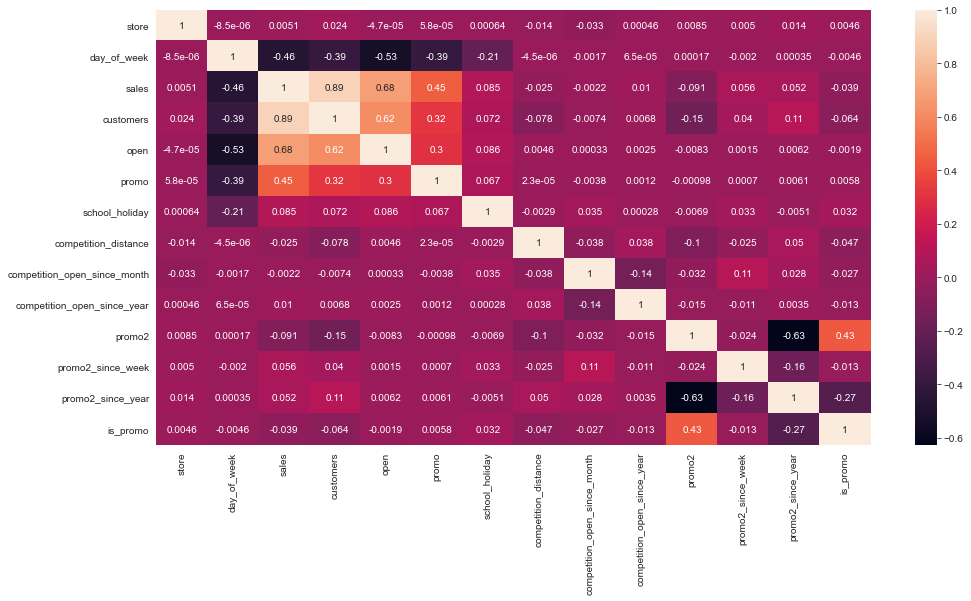

In [84]:

# Correlation between the numerical variables
correlation = num_attributes.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots the heatmap
sns.heatmap(correlation, annot=True)

# displays the plot
plt.show()

### 4.3.2. Categorical Attributes 

To calculate the correlation between two categorical attributes, we use association measure. And an association measure that will use, in this case, is **Cramer's V**. 


Before defining **Cramer's V**, we need to define the mean quadratic contingency coefficient that uses the $ \chi^ {2}$ statistic value itself as a measure of association, but since $\chi^{2}$ depends on $n$, this implies that the measure is increasing by $n$. Thefore, the mean quadratic contingency coefficient is given by

$\varphi^{2} = \frac{\chi^{2}}{n}$.


Thus, Cramer's V is given by the equation

$V = \sqrt{\frac{\varphi^{2}}{min(k-1, r-1)}} = \sqrt{\frac{\frac{\chi^{2}}{n}}{min(k-1, r-1)}}$,

where

$\varphi$ is the coeficient

$\chi^{2}$ is derived from Peason's chi-squared test

$n$ is the grand total of observations 

$k$ being the number of columns 

$r$ being the number of rows


The Cramer's V coefficient varies between 0 and 1. Thus, if  the value is approach to 1 have strong correlation (strong dependence) and approach to 0 have weak correlation (strong independence).


However, **Cramer's V** can be a highly biased estimator of its population counterpart. Soon, it will tend to overestimate the strength of the association. Therefore, a **bias correction** is made using the equation above which is

$ \tilde{V} = \sqrt{\frac {\tilde{\varphi}^{2}}{\min(\tilde{k}-1,\tilde{r}-1)}}$

where,

$ \tilde{\varphi }^{2}=\max\left(0,\varphi ^{2}-{\frac {(k-1)(r-1)}{n-1}}\right) $

and 

$\displaystyle\tilde{k}=k-\frac {(k-1)^{2}}{n-1}$ e $ \displaystyle\tilde {r}=r-{\frac {(r-1)^{2}}{n-1}} $.

It will be made the Cramer's V calculation using the code below.

**OBS**: Python calculate the chi-squared statistic importing scipy library.

In [85]:
#categorical variables from the dataset
df_cv= df4.select_dtypes(include='object')
df_cv.head()

,state_holiday,store_type,assortment,year_week,before_after
0,regular_day,c,basic,2015-30,after_10_days
1,regular_day,a,basic,2015-30,after_10_days
2,regular_day,a,basic,2015-30,after_10_days
3,regular_day,c,extended,2015-30,after_10_days
4,regular_day,a,basic,2015-30,after_10_days


In [86]:
#removing col before_after
col = ['before_after']
df4 = df4.drop(col, axis = 1)

In [87]:
#categorical variables from the dataset
df_cv= df4.select_dtypes(include='object')
df_cv.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [88]:
#confusion matrix 
cm = pd.crosstab(df_cv['state_holiday'], df_cv['store_type']).values

In [89]:
#chi-squared
chi2 = ss.chi2_contingency(cm) [0]
chi2 #test chi-square result

# sum of all values of the confusion matrix
n = cm.sum()

#number of rows and columns
r, k = cm.shape

print(f'Test: {chi2}')
print(f'sum of the values of the confusion matrix: {n}')
print(f'number of rows and columns: {r, k}')

Test: 12792.159524019908
sum of the values of the confusion matrix: 844338
number of rows and columns: (4, 4)


In [90]:
# calculates Cramér V
cramer_v = np.sqrt((chi2/n) / min(k-1, r-1))
print(f'Cramer V: {cramer_v}')

Cramer V: 0.07106457093267678


It were be made the Cramer's V calculation doing the calculate of each term. Now, let's define a general function to calculate the categorical variables. Thus,

In [91]:
#cramer V
def cramer_v(var_x, var_y):
    # builds contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    #sum of all values in the matrix
    n = confusion_matrix.sum()
    
    # rows, cols
    r, k = confusion_matrix.shape
    
    #chi-squared
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    
    # bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    #returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

Using the defined cramer_v function to make the calculations

In [92]:
#combinations between categorical variables
a1 = cramer_v(df_cv['state_holiday'], df_cv['state_holiday'])
a2 = cramer_v(df_cv['state_holiday'], df_cv['store_type'])
a3 = cramer_v(df_cv['state_holiday'], df_cv['assortment'])

a4 = cramer_v(df_cv['store_type'], df_cv['state_holiday'])
a5 = cramer_v(df_cv['store_type'], df_cv['store_type'])
a6 = cramer_v(df_cv['store_type'], df_cv['assortment'])

a7 = cramer_v(df_cv['assortment'], df_cv['state_holiday'])
a8 = cramer_v(df_cv['assortment'], df_cv['store_type'])
a9 = cramer_v(df_cv['assortment'], df_cv['assortment'])

# dataset of the correlations
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9],
             })

#index equal to columns
d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


Thus, we can plots the correlations of the categorical variable.

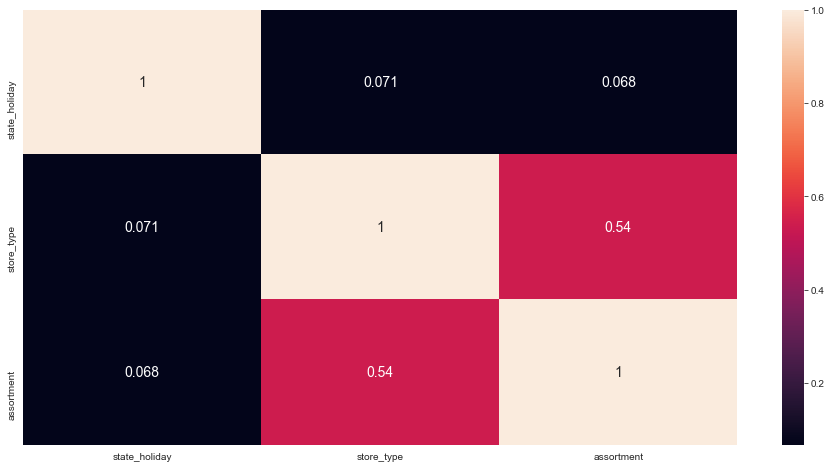

In [93]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots the heatmap
sns.heatmap(d, annot=True, annot_kws={"fontsize":14})

# displays plot
plt.show()

According to the heat map, we can conclude that the larger correlation occurs between *assortment* and *store type*. The result of 0.54 is a medium correlation. This means that the bigger the store, the higher is assortment of its products.With respect to the correlations of the other variables close to zero, we can conclude that they are weak and independent.

# 5.0. STEP 05 - Data Preparation

In this step, we will do the data preparation, which is the data modelation for Machine Learning training. The reason for this is that learning most machine learning algorithms is made easy with numerical data on the same scale.

#### How to prepare data ?

There are basically three process of data preparation that we can use: **Normalization**, **Rescaling** and **Transformation**.

This processes are explains in the subsections. Before, let's make a copy of the dataset.










In [94]:
#make a copy 
df5 = df4.copy()

## 5.1. Normalization

The normalization process works for those variables that have a normal distribution. Thus, normalization takes variables with these characteristics and transforms them into standardized normal distributions, that is, normal distributions with mean 0 and standard deviation 1. The equation below describe the process

$Z = \dfrac{x - \mu}{\sigma}$,

where

$\mu$ = mean

$\sigma$ = standard deviation.

In this process, we have that see the distributions of the univariable analysis that have a normal distribution.

Checking the distributions, we conclude that no distribution is normal. Therefore, we don't make nothing. 

## 5.2. Rescaling

The rescaling process works for those variables that do not have a normal distribution, that is, the variables have non-Gaussian distributions. Therefore, their intervals are rescalled containing mean 0 and standard deviation 1.



In [95]:
#select the numerical variables
a = df5.select_dtypes(include = ['int32', 'int64', 'float64'])

In [96]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


There are two methods of rescaling that we can to use in the variables. They are: **Min-Max-Scaler** and **Robuster-Scaler**

#### Min-Max-Scaler

Basically, in this method, we going to take column of the association variable that we want transforms e and apply the equation below

$ X_{new} = \dfrac{X_{i} - \mu}{X_{max} - X_{min}}$,

where

$X_{new}$ = new value of the variable

$X_{i}$ = value of the column in the variable.

$\mu$ = median variable

$X_{max}$ = maximum value corresponds to the variable

$X_{min}$ = minimum value corresponds to the variable

The Min-Max-Scaler application does not change the nature of the variables, maintaining the distributions. What will change is only the interval. But, the Min-Max-Scaler application presents a problem that is related to the outliers of the variables because considering these values in the equation can bring the transformed data results very close to zero of the new scale generating a cluster.  And that takes the format out of the distribution.

Therefore, we can use the Robuster-Scaler method that uses quartiles instead of the maximum and minimum value.


#### Robuster-Scaler

In the same way as the previous, we going to take column of the association variable that we want transforms and apply the equation below

$ X_{new} = \dfrac{X_{i} - Q_{1}}{Q_{3} - Q_{1}}$

where

$X_{i}$ = value of the column in the variable.

$Q_{1}$ = first quartile

$Q_{3}$ = third quartile

Robust-Scaler is a method that can solve the outliers problem faced in Min-Max-Scale, because it uses Q1 and Q3. Thus, to apply one of the presented methods, we need to analyze the boxplot of each variable. So, if the assigned variable has many outliers we use Robust-Scaler. Otherwise, we use Min-Max-Scaler. 

Therefore, we will analyze the boxplots of each variable chosen and apply the methods.


**OBS**: This methods make part of the **sklearn.preprocessing** library.


In [97]:
# Rescaling technics
rs = RobustScaler()
mms = MinMaxScaler()

### 5.2.1 Rescaling competition_distance

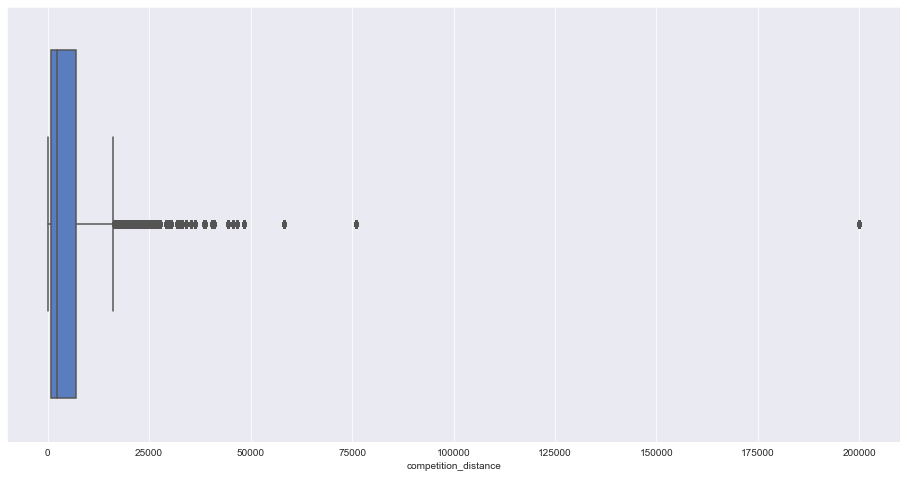

In [98]:
#plot boxplot for check outliers

fig, ax = plt.subplots()

#size of the figure
ax.figure.set_size_inches(16,8)

ax = sns.boxplot(df5['competition_distance'])

plt.show()

As observed in the results, there is a clear presence of outliers.

In [99]:
#rescaling competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
df5['competition_distance'].head()

0   -0.170968
1   -0.283871
2    1.903226
3   -0.275806
4    4.448387
Name: competition_distance, dtype: float64

### 5.2.2 Rescaling competition_time_month

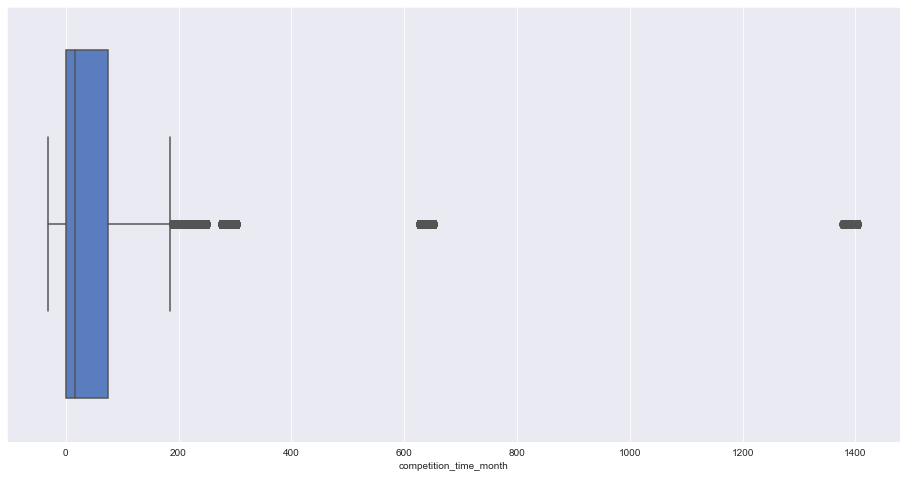

In [100]:
#plot boxplot for check outliers

fig, ax = plt.subplots()

#size of the figure
ax.figure.set_size_inches(16,8)

ax = sns.boxplot(df5['competition_time_month'])

plt.show()

As observed in the results, there is a clear presence of outliers.

In [101]:
#rescaling competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
df5['competition_time_month'].head()

0    0.918919
1    1.054054
2    1.202703
3    0.743243
4   -0.162162
Name: competition_time_month, dtype: float64

### 5.2.3 Rescaling promo_time_week

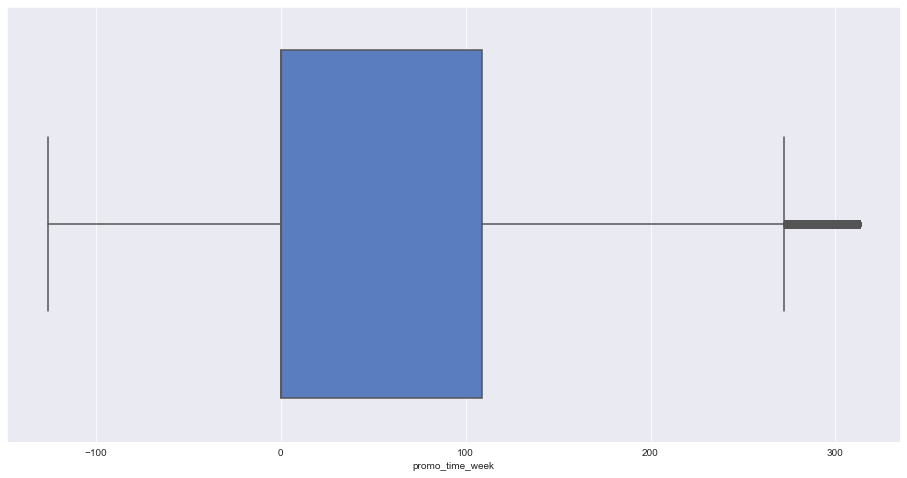

In [102]:
#plot boxplot for check outliers

fig, ax = plt.subplots()

#size of the figure
ax.figure.set_size_inches(16,8)

ax = sns.boxplot(df5['promo_time_week'])

plt.show()

As observed in the results, there is a clear presence of outliers. However, they are not that far from the superior whisker. So we can take a chance to use the Min-Max Scaler.

In [103]:
#rescaling promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
df5['promo_time_week'].head()

0    0.287016
1    0.922551
2    0.801822
3    0.287016
4    0.287016
Name: promo_time_week, dtype: float64

### 5.2.4 Rescaling year

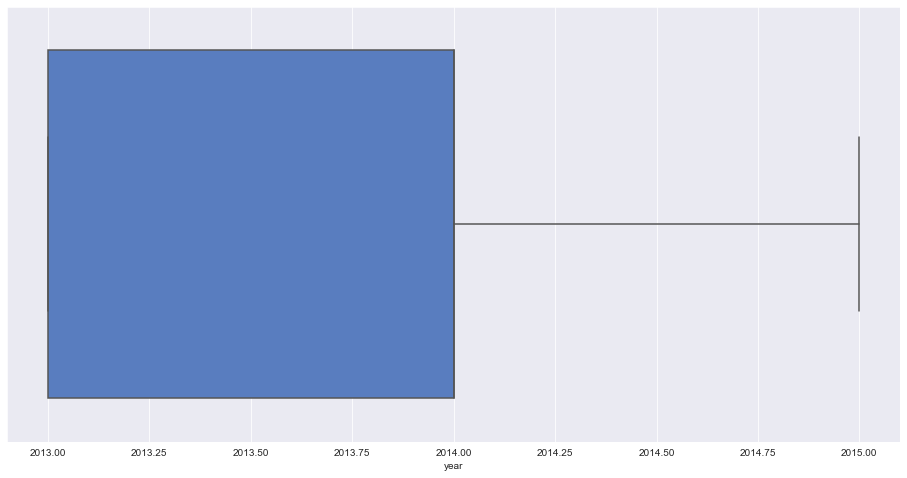

In [104]:
#plot boxplot for check outliers

fig, ax = plt.subplots()

#size of the figure
ax.figure.set_size_inches(16,8)

#plot the boxplot
ax = sns.boxplot(df5['year'])

plt.show()

In [105]:
#rescaling promo_time_week
df5['year'] = mms.fit_transform(df5[['year']].values)
df5['year'].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: year, dtype: float64

### 5.2.5. Rossmann's Class Parameters 

In [106]:
#rescaling competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('C:/Users/diasn/projetos/DataScienceEmProducao/parameter/competition_distance_scaler.pkl', 'wb' ))

#rescaling competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('C:/Users/diasn/projetos/DataScienceEmProducao/parameter/competition_time_month_scaler.pkl', 'wb' ))

#rescaling promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('C:/Users/diasn/projetos/DataScienceEmProducao/parameter/promo_time_week_scaler.pkl', 'wb' ))

#rescaling year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('C:/Users/diasn/projetos/DataScienceEmProducao/parameter/year_scaler.pkl', 'wb' ))

## 5.3. Transformation

In the data preparation process of transformation, let's to check three techniques: **Encoding**, **Response Variation Transformation** and **Nature Transformation**

### 5.3.1. Encoding

In the Encoding tecnique, we convert the categorical variable into 
numerical variable maintaining information content. So, we will use **One Hot Encoding**, **Label Encoding** and **Ordinal Encoding**.


#### 5.3.1.1. One hot Encoding

One-hot encoding is used in machine learning as a tecnique to quantify categorical data. In short, this tecnique produces a vector with length equal to the number of categories in the data set.  If a data point belongs to the

ith category then components of this vector are assigned the value 0 except for the ith component, which is assigned a value of 1.  In this way one can keep track of the categories in a numerically meaningful way.

Let's use the One Hot Encoding in the "state_holiday" variable.

In [107]:
#state holiday - One Hot Enconding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

In [108]:
# check the dataset
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


As we observed, the tecnique was applied to the "state_holiday" variable.

#### 5.3.1.2. Label Encoding

Label Encoding is a popular encoding technique handling categorical variables. In the tecnique, each label is assigned a unique integer based on alphabetical ordering. Let's see how it works in the "store_type" variable.

In [109]:
from sklearn.preprocessing import LabelEncoder

# Label Enconder
le = LabelEncoder()

In [110]:
#store type
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('C:/Users/diasn/projetos/DataScienceEmProducao/parameter/store_type_scaler.pkl', 'wb' ))

In [111]:
#check the dataset
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


As we observed, the tecnique was applied to the "story_type" variable.

#### 5.3.1.3. Ordinal Encoding

Ordinal Encoding is used to transform non-numerical labels into numerical labels (or nominal categorical variables). Numerical labels are always between 1 and the number of classes.

The labels chosen for the categories have no relationship. So categories that have some ties or are close to each other lose such information after encoding. The first unique values in your column becomes 1, the second becomes 2, the third becomes 3, and so on.

In the case, we will apply the tecnique to the assortment variable, we don't need to import a library, we can just create a dictionary. So, we have:

In [112]:
#assortment - a ordem importa 
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}

#map of the names
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [113]:
#checking dataset
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


As we observed, the tecnique was applied to the "assortment" variable.

### 5.3.2. Response Variable Transformation

In the response variable transformation, we have that to approximate the distribution response variable to a normal distribution. This is necessary because machine learning algorithms are built on certain assumptions, and one such assumptions is that data are normally distributed. 

Thus, to do this, we'll use the logarithmic transformation method according to the code.

In [114]:
#applies the logarithm
df5['sales'] = np.log1p(df5['sales'])

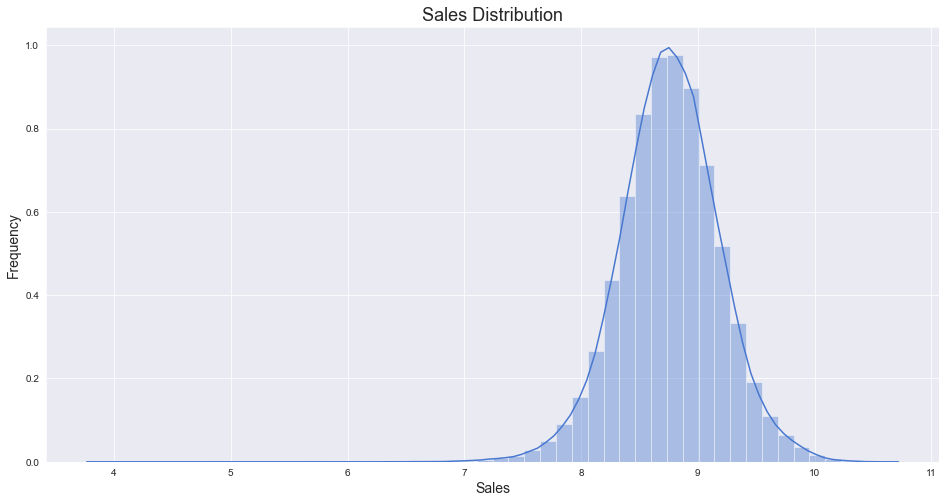

In [115]:
fig, ax = plt.subplots()

#size of the figure
ax.figure.set_size_inches(16,8)

#plots a distplot
ax = sns.distplot(df5['sales'])

#title and axis labels
set_plots_features(ax, 'Sales Distribution','Sales','Frequency')

#display the plot
plt.show()

### 5.3.3. Nature Transformation

In the transformation of nature, we have to bring the true nature of the data into the data set. For example, we have the variable month that needs to be transformed because it is a cyclical variable, that is, the months are repeated each year that closes. But for that we don't just list the months 1 to 12, because if we leave the months listed, we lose the sense of the cycle because of the different distances. For example, we take the month of January 2018, we verify that it is a long distance until December 2018, but not necessarily, December 2018 is far from the month of January 2019. What happens is that December 2018 has the same distance from January 2019 as March 2018 has from April 2018. And the same distances keep the cycle.

Therefore, we use the trigonometric circle by placing the months as arcs and separating them at equal distances.

This process is made for the variables day of week, month, day, week of year.

In [116]:
#variables with cyclical nature

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52)))

In [117]:
#checking dataset
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. STEP 06 - FEATURE SELECTION

In this module 06, we will make the feature selection. It is important to facilitate the understanding of the machine learning algorithms. So, we need to use simpler models that involve the data set having a number of right columns.

The feature selection will verify which variables of the data set are collinear, that is, variables that explain the same information, to remove them because variables of this type are not necessary to use. 

There are some types of feature selection as: Filter Methods, Embedded Methods, Wrapper Methods and Boruta. 

The method that will be used, in this project, is Boruta. Thus, we will to make a copy of the dataset to continue the project.

In [118]:
#copying the dataset
df6 = df5.copy()

In [119]:
#dropping columns
cols= ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

#drop the given columns
df6 = df6.drop(cols, axis = 1)

In [120]:
#ckecking the dataset
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 6.1. Split Dataframe Into training and Test Datasets

we will separate our dataset in training and test. Thus

In [121]:
# gets the first sales dates for each store
df6[['store', 'date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [122]:
#gets the last sales dates for each store
df6[['store', 'date']].groupby('store').max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [123]:
#gets the date before the last 6 weeks of sales for each store. 
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [124]:
#creating the training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#creating the test dataset
X_test = df6[df6['date'] >= '2015-06-19' ]
Y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min() ) )

print('Training Max Date: {}'.format(X_train['date'].max() ) )

print('Test Min Date: {}'.format(X_test['date'].min() ) )

print('Test Max Date: {}'.format(X_test['date'].max() ) )



Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [125]:
#define training and test data for Boruta - pq não pode passar um dataframe tem que passar um vetor de numeros
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
Y_train_n = Y_train.values.ravel()

In [126]:
#define RamdomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

**NOTE**: As the Boruta algorithm takes a long time to run, approximately 5 hours, we will consider the best variables already achieved at first. This way, the Boruta code that calculates these variables will be commented.

In [127]:
#define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

### 6.2.1. Best Features from Boruta

In [128]:
# list of features by the Boruta
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list

#not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs, cols_selected_boruta))

# Analisar as melhores features com as hipoteses relevantes

# 6.3. Manual Feature Selection

In [129]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos',
   ]

In [130]:
#inserting variables
feat_to_add = ['date', 'sales']

#final selected features
#cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [131]:
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. STEP 07 - MACHINE LEARNING MODELLING

In this module, we will make the Machine Learning Modelling. The motivation to the use Machine Learning Algorithms is to learn the sales behavior with the available variables and then generalize it for the future.

There are various types of Machine Learning algorthms. For this project, we will use supervised task algorithms in which the regression techniques are applied. Before of all, we need to separate the data.

### 7.0.1. Separating the data

In [132]:
# selects only the cols where selected by Boruta
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

In [133]:
# creates dataset for test
aux1 = x_test.copy()

In [134]:
aux1['sales'] = Y_test.copy()

## 7.1. Average Model

In [135]:

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(Y_test) , np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [136]:
#model
lr = LinearRegression().fit(x_train, Y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [137]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,MAE CV,MAPE CV,RMSE CV
0,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [138]:
#model
lrr = Lasso(alpha= 0.01).fit(x_train, Y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso - Cross Validation

In [139]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,MAE CV,MAPE CV,RMSE CV
0,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [140]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.622763,0.09996,1011.191561


### 7.4.1. Random Forest Regressor - Cross Validation

In [ ]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
#rf_result_cv

In [141]:
rf_result_cv = pickle.load(open('/Users/diasn/DS/DataScienceEmProducao/rf_result_cv.pkl', 'rb'))

In [142]:
rf_result_cv

,MAE CV,MAPE CV,RMSE CV
0,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36


## 7.5. XGBoost Regressor

In [143]:
#model
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror', n_estimators=100, eta = 0.01, max_depth = 10, subsample = 0.7,colsample_bytee = 0.9).fit( x_train, Y_train)
#prediction
yhat_xgb = model_xgb.predict(x_test)
#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112292,0.122609,1250.952634


### 7.5.1. XGBoost Regressor - Cross Validation

In [ ]:
#xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)

In [144]:
xgb_result_cv = pickle.load(open('/Users/diasn/DS/DataScienceEmProducao/xgb_result_cv.pkl', 'rb'))

In [145]:
xgb_result_cv

,MAE CV,MAPE CV,RMSE CV
0,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [146]:
modelling_result  = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values( 'RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.622763,0.099960,1011.191561
0,XGBoost Regressor,843.112292,0.122609,1250.952634
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2. Real Performance - Cross Validation

In [147]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,MAE CV,MAPE CV,RMSE CV
0,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36
0,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


   # 8.0. STEP 08 - HYPERPARAMETER FINE TUNING

The module of Hyperparameter Fine Tuning serves to find the set of parameters that maximize the learning of the model.

There are three strategies of Hyperparameter Fine Tuning:

- Random Search - Defines values for each of the hyperparameters randomly.

- Grid Search - Defines all possible combinations of values that hyperparameters can assume.

- Bayesian Search - Defines the values for the hyperparameters following Bayes's Theory.

For the project, we will use the **Random Search** because it is fast to execute and easy to implement.

## 8.1. Random Search

In [148]:
param = { 
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 10

In [ ]:
# conforme os parametros escolhidos, o random search demora para fazer as escolhas

#final_result = pd.DataFrame()

#for i in range( MAX_EVAL):
    #Choose values for parameters ramdomly
    #hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    #print(hp)
    #model
    #model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror', 
                                  #n_estimators=hp['n_estimators'], 
                                  #eta = hp['eta'], 
                                  #max_depth = hp['max_depth'], 
                                  #subsample = hp['subsample'], 
                                  #colsample_bytee = hp['colsample_bytree'],
                                  #min_child_weight = hp['min_child_weight'])

    #performance
    #result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
    #final_result = pd.concat([final_result, result])

#final_result

#Selecionou os parametros da linha 2 para colocar no modelo final depois que o Random Search concedeu parametros randomizados.

In [149]:
cv = {'Model Name': ['XGBoost Regressor', 'XGBoost Regressor', 'XGBoost Regressor', 'XGBoost Regressor', 'XGBoost Regressor'],
      'MAE CV': [1112.91 , 1104.41, 896.48, 890.79, 1113.26 ],
      'STD MAE CV':[138.13, 133.24, 152.07, 149.22, 130.60],
      'MAPE CV': [0.16, 0.15, 0.13, 0.13, 0.16],
      'STD MAPE CV': [0.01, 0.01, 0.02, 0.02, 0.01],
      'RMSE': [1586.60, 1568.59, 1270.46, 1272.94, 1583.53], 
      'STD RMSE CV': [179.02, 171.77, 214.55, 214.22, 174.07]}

fr = pd.DataFrame(cv)
fr

,Model Name,MAE CV,STD MAE CV,MAPE CV,STD MAPE CV,RMSE,STD RMSE CV
0,XGBoost Regressor,1112.91,138.13,0.16,0.01,1586.60,179.02
1,XGBoost Regressor,1104.41,133.24,0.15,0.01,1568.59,171.77
2,XGBoost Regressor,896.48,152.07,0.13,0.02,1270.46,214.55
3,XGBoost Regressor,890.79,149.22,0.13,0.02,1272.94,214.22
4,XGBoost Regressor,1113.26,130.60,0.16,0.01,1583.53,174.07


## 8.2. Final Model

The **param_tuned** variable parameters were chosen according to the results in row 2 of the table above. The metrics were established by Random Search. 

**NOTE**: Since Random Search takes time to choose the parameters, it was not executed. The parameters were taken together with the training instructor. 

In [158]:
param_tuned = { 
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5, 
    'subsample': 0.7,
    'colsample_bytree': 0.7 ,
    'min_child_weight': 3 
        }

In [ ]:
#model
model_xgb_tuned = xgb.XGBRegressor( objective = 'reg:squarederror', 
                                   n_estimators=param_tuned['n_estimators'],
                                   eta = param_tuned['eta'], 
                                   max_depth = param_tuned['max_depth'], 
                                   subsample = param_tuned['subsample'], 
                                   colsample_bytee = param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train, Y_train)
#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

## 8.3. Saving the Model 

**NOTE**: Since maximizing the final model takes time to run, we run the model result once and save using the pickle package.

In [150]:
model_xgb_tuned = pickle.load(open('/Users/diasn/projetos/DataScienceEmProducao/pickle/model_rossmann.pkl', 'rb'))

In [151]:
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

In [152]:
yhat_xgb_tuned

array([ 8.610663,  8.553743,  9.168833, ...,  8.846759, 10.072041,
        9.131205], dtype=float32)

In [155]:
xgb_result_tuned = pickle.load(open('/Users/diasn/projetos/DataScienceEmProducao/pickle/xgb_result_tuned.pkl', 'rb'))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974996,0.097529,957.774225


# 9.0. ERROR TRANSLATION AND INTERPRETATION

In the module of Error Translation and Interpretation, we'll to analyse the Business Performance and Total Performance of Model. This is important to understand the model's performance and to tell the CEO how much money this model will bring to the company.

There, we have

In [156]:
df9 = X_test[cols_selected_boruta_full]

As we have applied variable transformation, we need to transform them back to their original scale.

In [157]:
#Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [158]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE - Report business values
#MAE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], 
                                                              x['predictions'])).reset_index().rename(columns = {0:'MAE'})
#MAPE
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], 
                                                              x['predictions'])).reset_index().rename(columns = {0:'MAPE'})
#merge - store, MAE, MAPE
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')

#merge - store, predictions, MAE, MAPE
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Creates Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [159]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,162606.312500,162299.567548,162913.057452,306.744952,0.070183
1,2,170870.984375,170449.574879,171292.393871,421.409496,0.087380
2,3,262130.968750,261543.968466,262717.969034,587.000284,0.084673
3,4,345748.687500,344893.119075,346604.255925,855.568425,0.081451
4,5,171662.046875,171299.253712,172024.840038,362.793163,0.079369


In [160]:
df92.sort_values('MAPE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.078125,100714.973723,107351.182527,3318.104402,0.565828
908,909,238233.875000,230573.337190,245894.412810,7660.537810,0.520433
875,876,203030.156250,199110.952456,206949.360044,3919.203794,0.305099
721,722,353005.781250,351013.625224,354997.937276,1992.156026,0.268338
594,595,400883.625000,397415.263170,404351.986830,3468.361830,0.242192


As observed in the results, we need to report to the business that there are stores that are more difficult to make the predictions.

Some strategies that may solve this challenge in the next CRISP iteration could be taking a closer look on the variables, try other methods, try other techniques.

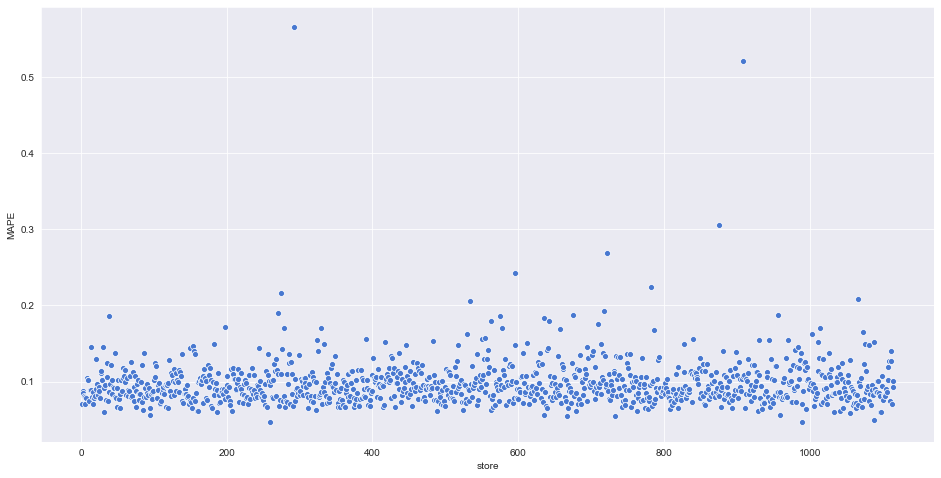

In [161]:
#creates ax 
fig, ax = plt.subplots()

#set figure size
ax.figure.set_size_inches(16,8)

#plot the data
ax = sns.scatterplot(x ='store', y='MAPE', data = df92 )

#displays the plot
plt.show()

Observing the results, we can see that there are stores that have higher MAPE values. So, these are the stores that presents challeging predictions.

## 9.2. Total Performance

In [162]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), 
                                                               axis = 0).reset_index().rename(columns={'index':'Scenario',
                                                                                                       0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)

df93

,Scenario,Values
0,predictions,"R$285,860,497.74"
1,worst_scenario,"R$285,115,015.68"
2,best_scenario,"R$286,605,979.81"


## 9.3. Machine Learning Performance

In [163]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

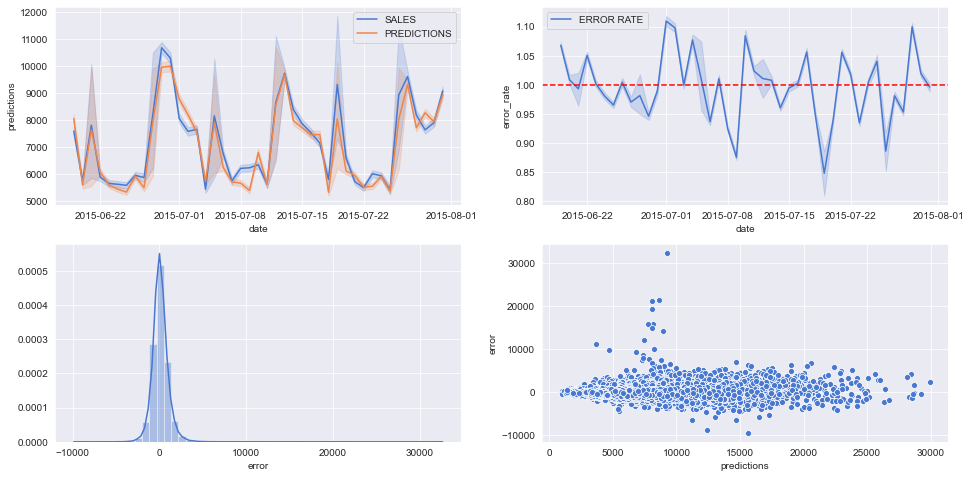

In [164]:
# create Axis
fig, ax = plt.subplots()

# set figure size
ax.figure.set_size_inches(16, 8)

# plots the data
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')


# plots the data
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9, label='ERROR RATE')
plt.axhline(1, linestyle='--', color='r')


# PLOTS FOR RESIDUAL ANALYSIS
# plots the data
plt.subplot(2, 2, 3)
sns.distplot(df9['error'])


# plots the data
plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])


# displays the plot
plt.show()

Observing the results, we can see that:

- By observing the first and second line plots, we can see that the predictions or our model is pretty close to the real value for sales. On the other hand, the error rate has some variance.

- By observing the histogram, the error distribution almost follows a normal distribution.

- By observing the scatterplot for the errors, the points seems well fit in a horizontal tube which means that there's a few variation in the error. If the points formed any other shape (e.g opening/closing cone or an arch), this would mean that the errors follows a trend and we would need to review our model.

# 10. STEP 10 - DEPLOY MODEL TO PRODUCTION

## 10.1. Rossmann Class

In [173]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann(object):
    def __init__(self):
        self.home_path ='C:/Users/diasn/projetos/DataScienceEmProducao/'
        self.competition_distance_scaler    = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler  = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler         = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                    = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler              = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
        
        
        
        
    def data_cleaning(self, df1):
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
                    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'] 
                

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        df1.columns = cols_new


        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA - Do away with empty cells
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) 
                                                    else x['competition_open_since_month'], axis = 1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                                   else x['competition_open_since_year'], axis = 1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                             else x['promo2_since_week'], axis = 1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                             else x['promo2_since_year'], axis = 1)

        #promo_inteval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                                     else 1 if x['month_map'] in x['promo_interval'].split(',') 
                                                                     else 0, axis = 1)

        ## 1.6. Change Types
        #competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
    
        #promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
    
        return df1

    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                month = x['competition_open_since_month'], day= 1), axis = 1)

        #competition time month
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        #promo_since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') 
                                                      - datetime.timedelta(days = 7) )

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/ 7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                      if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        # 3.0. STEP 03 - VARIABLE FILTERING
        
        ## 3.1. Row Filtering 
        df2 = df2[(df2['open'] != 0)]

        ## 3.2. Column Selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2

    #select the numerical variables
    #a = df5.select_dtypes(include = ['int32', 'int64', 'float64'])    
    
    def data_preparation(self, df5):

        ## 5.2. Rescaling
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #rescaling promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #rescaling promo_time_week
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        #state holiday - One Hot Enconding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        #store type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment - Ordinal Enconding 
        assortment_dict = {'basic': 1,'extra': 2,'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

    
        ### 5.3.3. Nature Transformation
        #variables with cyclical nature

        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7)))

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12)))

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30)))

        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
            'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
            'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos',
            'week_of_year_sin','week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction( self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json( orient = 'records', date_format = 'iso')

   ## 10.2. API Handler

In [174]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('C:/Users/diasn/projetos/DataScienceEmProducao/pickle/model_rossmann.pkl', 'rb'))

#iniatialize API
app = Flask( __name__ )

@app.route('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance(test_json, dict): #unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: #multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        #Instantiate Rossmann Class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction 
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('192.168.0.18')

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [165]:
import json

In [166]:
import requests

In [167]:
#loading test dataset
df10 = pd.read_csv('/Users/diasn/projetos/DataScienceEmProducao/data/test.csv')

In [168]:
#merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

#choose store for prediction
df_test = df_test[df_test['Store'].isin([20, 12, 22])]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [169]:
# convert DataFrame to json - Json List
data = json.dumps(df_test.to_dict(orient = 'records'))

In [170]:
#API Call
#url = 'http://192.168.0.18:5000/rossmann/predict'
url = 'https://rossm-nn.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'} 
data = data

r = requests.post(url, data=data, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [171]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys() )

In [172]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'],
                                                                           d2.loc[i, 'prediction']))

Store number 12 will sell R$268,636.28 in the next 6 weeks
Store number 20 will sell R$293,525.62 in the next 6 weeks
Store number 22 will sell R$140,049.36 in the next 6 weeks
